# Demo of the BGTM on 2-Dimensional Joe-Copula

In this demonstration we show how the GTM can be used to learn a probability distribution from synthetic data sampled from a 2 dimensional Joe copula.
To sample synthetic copula data we use the [pyvinecopulib](https://github.com/vinecopulib/pyvinecopulib) library.
Fore more details on copulas we refer to the Book [Analyzing Dependent Data with Vine Copulas](https://link.springer.com/book/10.1007/978-3-030-13785-4) for an comprehensive introduction to copulas and vine copulas.

In [1]:
from gtm import *

# Sample Copulas Package
import pyvinecopulib as pv

# Other Stuff
import numpy as np
import torch
from torch.utils.data import DataLoader
from dataset_helpers import Generic_Dataset
import matplotlib.pyplot as plt

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Loading Sanity Functions

In [2]:
def sanity_check(model, use_softplus=False, transformation_grad=1):

    model_dict = dict(model.state_dict())
    print(model_dict.keys())

    if not use_softplus:
        a = model.transformation.params[transformation_grad].detach().cpu()
        eps = torch.empty_like(a)
        eps[0] = a[0]
        eps[1:] = torch.nn.functional.softplus(a[1:])
        eps = torch.cumsum(eps, dim=0)
    
    is_mono = torch.all(torch.diff(eps) > 0)
    print(is_mono.item())
        
    print(f"{eps}")  # should be strictly increasing
    plt.plot(range(len(eps)), eps, marker='o')
    plt.title("Monotonic spline coefficients ε_j,p")
    plt.xlabel("Basis index p")
    plt.ylabel("ε_j,p")
    plt.show()

def series(x):
    """Return a 1D numpy array from tensor OR list/tuple of (tensors|floats)."""
    if torch.is_tensor(x):
        return x.detach().cpu().numpy()
    if isinstance(x, (list, tuple)):
        return np.array([t.detach().cpu().item() if torch.is_tensor(t) else float(t) for t in x])
    return np.asarray(x)

#### Hyperparameter choice

In [3]:
hyperparameters = {
    "transformation": {
    "sigma_a": 2.1, "sigma_b": 1e6,        #Ignored not used
    
    #"RW2": {"tau_a": 1e-3, "tau_b": 1e-3},   # A) nearly-flat proper  ← recommended
    "RW2": {"tau_a": 1.1,  "tau_b": 1e-3},   # B) weak default
    # "RW2": {"tau_a": 1.0,  "tau_b": 1.0},    # C) unit-scale neutral
    
    "RW1": { "tau_a": 10.0,"tau_b": 15.0 }  #Ignored not used
    },
    "decorrelation": {
    "sigma_a": 2.1, "sigma_b": -1e6,              # mean σ² = very small close to 0 (weak)
    "RW2": { "tau_a": 1.5, "tau_b": 0.01 },      # E[κ2] ≈ 0.05   (weak curvature smoothing)
    "RW1": { "tau_a": 1.5, "tau_b": 0.01 },      # E[κ1] ≈ 0.10   (light shrink to linear)
    }
}

# Test 1 ndependence copula + standard Gaussian marginals (N(0,1))

### 1. Sample Synthetic Copula Data and Compute Likelihoods

We sample data from a Independent Copula and add Gaussian marginals.
The list of copulas can be found with `help(pv.Bicop)`.

Notice we use Sklars Theorem to compute the density of the joint copula and Gaussian marginals density.

In [4]:
copula_pv = pv.Bicop(family=pv.BicopFamily.indep)


# Train
N_train = 2000
simulated_data_uniform_train = copula_pv.simulate(n=N_train)
simulated_data_train = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_train)).float()

# Validate
N_validate = 2000
simulated_data_uniform_validate = copula_pv.simulate(n=N_validate)
simulated_data_validate = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_validate)).float()

# Test
N_test = 20000
simulated_data_uniform_test = copula_pv.simulate(n=N_test)
simulated_data_test = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_test)).float()

In [5]:
loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
loglik_true_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
loglik_true_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_test)).sum(1)
loglik_true_test = torch.tensor(loglik_copula) + log_marginals

/tmp/ipykernel_1189396/2085715786.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
/tmp/ipykernel_1189396/2085715786.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
/tmp/ipykernel_1189396/2085715786.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_da

We further estimate the copula on the synthetic data to get an oracle denisity estimator. Hence an estimator that knows the true underlying structure and merely estiamtes the model parameters.

In [6]:
copula_pv_est = pv.Bicop(family=pv.BicopFamily.indep)
copula_pv_est.fit(simulated_data_uniform_train)
means = simulated_data_train.mean(0)
vars = simulated_data_train.var(0)

In [7]:
loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_train).sum(1)
loglik_true_est_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_validate).sum(1)
loglik_true_est_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_test).sum(1)
loglik_true_est_test = torch.tensor(loglik_copula) + log_marginals

The package is implemented to use Dataloaders for training. This is done to accommodate larger datasets trained batch wise as is common in deep learning and bioinformatics applications. Feel free to use the [`Generic_Dataset`](demos/dataset_helpers.py) class to easily adjust it to your data. For full data training, thus whithout batches simply seet the `batch_size` arguement in the `DataLoader` to the data size as we do in this example

In [8]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train = DataLoader(dataset_train, batch_size=300)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate = DataLoader(dataset_validate, batch_size=300)

### 2. Define Model

We define a simple GTM model with the standard parameters.
Notable custamizable parameter are: 
- The dimensionality of the data `number_variables`
- The number of transformation layers `num_trans_layers`, either 0 or 1.
- The number of decorrelation layers `num_decorr_layers`, typically 3 or more. 
- the spline to use for the transformation layer splines `spline_transformation` and the decorrelation layer splines `spline_decorrelation`.  The two types of layers: P-Splines (`bspline`) or bernstein polynomials (`bernstein`).
- The degrees of the splines, representing there flexibility, being `degree_decorrelation` for the decorrelation layer splines and `degree_transformations` for the transformation layer. When using `bspline`, then `degree_transformations` can also be given a list with varying degrees for each dimension of the data.
- `transformation_spline_range`sets the outer borders for the transformation layer splines, this dependends on the input data and should be set a bit wider then the actual data.
- `device` either `cpu`or `cuda`


In [9]:
model_freq = GTM(
    number_variables = 2,
    number_transformation_layers = 1,
    number_decorrelation_layers = 0,
    degree_transformations = 10,
    degree_decorrelation = 40,
    spline_transformation = "bspline",
    spline_decorrelation = "bspline",
    transformation_spline_range = (-10, 10),
    device = "cpu") 

penalty_splines_params=torch.FloatTensor([
                            0, #study.best_params["penalty_decorrelation_ridge_param"],
                            0,
                            0,
                            0 #study.best_params["penalty_transformation_ridge_second_difference"]
                              ])
adaptive_lasso_weights_matrix = False
penalty_lasso_conditional_independence=False

# pretrain the marginal transformations
output_freq = model_freq.pretrain_transformation_layer(dataloader_train, iterations=1000, max_batches_per_iter=False, penalty_splines_params=penalty_splines_params)

  0%|          | 0/1000 [00:00<?, ?it/s]/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_splines/bspline_prediction_vectorized.py:595: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  x=input_a_clone.T, t=knots.T, c=params_a.T, p=order, d=derivativ


current_loss: tensor(1.4712, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4680, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4618, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4582, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4459, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4411, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4865, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4685, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4003, grad_fn=<MeanBackward0>)
current_loss: 

  0%|          | 2/1000 [00:00<03:01,  5.49it/s]

tensor(1.3896, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4179, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4163, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4719, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4710, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4525, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4464, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4377, grad_fn=<MeanBackward0>)
current_loss: tensor(1.9326, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4369, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4198, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4179, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4683, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4654, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3857, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3846, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4157, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4156, grad_fn=<Mean

  0%|          | 3/1000 [00:00<02:40,  6.23it/s]

current_loss: tensor(158.5992, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4383, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4229, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4170, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4664, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5664, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4629, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3863, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3846, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4155, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4152, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4729, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4704, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4462, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4459, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4379, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4366, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4176, grad_fn=<MeanBackward0>)
current_loss: tensor(1.416

  0%|          | 5/1000 [00:00<02:26,  6.77it/s]

current_loss: tensor(1.4149, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4140, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4717, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4809, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4706, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4497, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4468, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4399, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4708, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4366, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4184, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4154, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4652, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6129, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4623, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3833, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3817, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4131, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4127,

  1%|          | 6/1000 [00:00<02:25,  6.84it/s]

current_loss: tensor(1.4438, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4348, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7204, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4340, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4174, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4154, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4687, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4653, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3804, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3797, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4126, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4124, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4733, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4728, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4709, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4446, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4444, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4362, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4352,

  1%|          | 8/1000 [00:01<02:15,  7.34it/s]

current_loss: tensor(1.3797, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4123, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4122, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4727, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4725, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4717, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4446, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4442, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4361, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4348, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4143, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4662, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4646, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3802, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3795, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4122, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4121, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4731,

  1%|          | 9/1000 [00:01<02:17,  7.22it/s]

current_loss: tensor(1.4372, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4134, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4134, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4133, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4637, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4638, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4635, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3807, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3799, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4119, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4118, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4113, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4710, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4705, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4467, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4457, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4381, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4456, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4361,

  1%|          | 11/1000 [00:01<02:15,  7.32it/s]

current_loss: tensor(1.3795, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3783, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4107, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4105, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4724, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4723, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4458, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4439, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4355, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7254, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4334, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4158, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4131, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4677, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4644, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3774, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3767, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4104, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4104,

  1%|          | 12/1000 [00:01<02:12,  7.48it/s]

current_loss: tensor(1.4355, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4344, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4128, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4125, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4661, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4650, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3774, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3767, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4104, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4103, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4737, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4733, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4717, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4438, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4437, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4340, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4335, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4170, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4140,

  1%|▏         | 13/1000 [00:01<02:31,  6.53it/s]

current_loss: tensor(1.4103, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4740, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4737, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4718, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4443, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4439, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4347, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4336, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4143, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4130, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4673, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4652, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3775, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3765, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4104, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4103, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4738, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4738, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4732,

The GTM class contains a number of plotting functions so that standard analysis can be done soley with the model:

### 3. Hyperparameter Tune and Train Model

To find the optimal penalties one uses the `hyperparameter_tune_penalties` function. Then using the optimal penalties one can train the model.

The training can be done by pretraining the marginal transformations with `pretrain_tranformation_layer` and then training jointly with `train`.
In general empirically we found that pretraining reduces training time and improves results allthough direct joint training also works.

Hyperparameter tuning can be done for the penalties `penvalueridge, penfirstridge , pensecondridge, ctm_pensecondridge, lambda_penalty_params` by passing the arguement `"sample"`.
If a fixed number is passed, typically zero, then for that penalty no hyperparameter drawing is done and the fixed values is used.


In [10]:
model = GTM(
    number_variables=2,
    number_transformation_layers=1,
    number_decorrelation_layers=0,
    degree_transformations=10,
    degree_decorrelation=40,
    spline_transformation="bspline",
    spline_decorrelation="bspline",
    transformation_spline_range=(-10, 10),
    device="cuda" if torch.cuda.is_available() else "cpu",
    ## NEW ARGUMENTS ##
    inference = 'bayesian',
    hyperparameter=hyperparameters
    )

model.transform_only = True


output = model.pretrain_transformation_layer(
                train_dataloader=dataloader_train,
                validate_dataloader=dataloader_validate,
                hyperparameters=None,
                iterations=200,
                #verbose=True,
                learning_rate=0.01,
                mcmc_sample_train=32,            # will ramp
                mcmc_sample_val=128,             # fixed & larger for stable eval
                mc_ramp_every=60,               # 4→8→16→32 at epochs 25/50/75
                mc_ramp_max=64,
                patience=30,                # early-stop patience
                min_delta=0.0001,                # ~0.1% absolute of your loss scale
                rho_lr_multiplier=0.1,          # slightly faster variance adaption (optional)
                sched_factor=0.7, sched_patience=8, sched_threshold=1e-4,
            )

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


First 30 param keys: ['transformation.params.0', 'transformation.params.1']


  0%|          | 0/200 [00:00<?, ?it/s]

[sanity] N=2000  current B=300  (training objective uses scaled likelihood & unscaled prior)


  0%|          | 1/200 [00:10<36:27, 10.99s/it]

[1/200] train=20381.9743  val_ELPD=-1.4647  S_train=32 S_val=128  lr=[0.01, 0.001]  σ̄=0.0503 σmin=0.0497 σmax=0.0503  N=2000 B=200 B̄≈285.7  lik/obs≈10.3  priors/obs: decor≈0 trans≈2.03e+04  tau4=0.600833  rank=20  E_qf_mean≈18.5  E_qf_total≈36.9  tau*E_qf≈22.2  target≈22.2  resid≈-2.03e+04  Δ=-1.10e+03μ-nudge(±)≈0.496


  1%|          | 2/200 [00:21<35:18, 10.70s/it]

[2/200] train=71.6934  val_ELPD=-1.4720  S_train=32 S_val=128  lr=[0.01, 0.001]  σ̄=0.0503 σmin=0.0497 σmax=0.0503  N=2000 B=200 B̄≈285.7  lik/obs≈10.35  priors/obs: decor≈0 trans≈23.4  tau4=0.619244  rank=20  E_qf_mean≈17.9  E_qf_total≈35.8  tau*E_qf≈22.2  target≈22.2  resid≈0.33  Δ=+1.84e-02μ-nudge(±)≈1.47


  2%|▏         | 3/200 [00:32<34:53, 10.63s/it]

[3/200] train=72.0501  val_ELPD=-1.4817  S_train=32 S_val=128  lr=[0.01, 0.001]  σ̄=0.0503 σmin=0.0497 σmax=0.0503  N=2000 B=200 B̄≈285.7  lik/obs≈10.45  priors/obs: decor≈0 trans≈23  tau4=0.635093  rank=20  E_qf_mean≈17.5  E_qf_total≈35  tau*E_qf≈22.2  target≈22.2  resid≈0.277  Δ=+1.58e-02μ-nudge(±)≈0.326


  2%|▏         | 4/200 [00:42<34:28, 10.56s/it]

[4/200] train=71.4255  val_ELPD=-1.4835  S_train=32 S_val=128  lr=[0.01, 0.001]  σ̄=0.0503 σmin=0.0497 σmax=0.0503  N=2000 B=200 B̄≈285.7  lik/obs≈10.53  priors/obs: decor≈0 trans≈22.5  tau4=0.636708  rank=20  E_qf_mean≈17  E_qf_total≈34.1  tau*E_qf≈21.7  target≈22.2  resid≈0.275  Δ=+1.62e-03μ-nudge(±)≈1.07


  2%|▎         | 5/200 [00:52<34:08, 10.51s/it]

[5/200] train=70.3598  val_ELPD=-1.4790  S_train=32 S_val=128  lr=[0.01, 0.001]  σ̄=0.0503 σmin=0.0497 σmax=0.0503  N=2000 B=200 B̄≈285.7  lik/obs≈10.5  priors/obs: decor≈0 trans≈21.8  tau4=0.63991  rank=20  E_qf_mean≈16.6  E_qf_total≈33.2  tau*E_qf≈21.2  target≈22.2  resid≈0.532  Δ=+3.20e-03μ-nudge(±)≈1.29


  3%|▎         | 6/200 [01:03<33:54, 10.49s/it]

[6/200] train=69.4511  val_ELPD=-1.4782  S_train=32 S_val=128  lr=[0.01, 0.001]  σ̄=0.0503 σmin=0.0497 σmax=0.0503  N=2000 B=200 B̄≈285.7  lik/obs≈10.46  priors/obs: decor≈0 trans≈21.2  tau4=0.644628  rank=20  E_qf_mean≈16.2  E_qf_total≈32.3  tau*E_qf≈20.8  target≈22.2  resid≈0.762  Δ=+4.72e-03μ-nudge(±)≈-0.743


  4%|▎         | 7/200 [01:13<33:39, 10.47s/it]

[7/200] train=69.0429  val_ELPD=-1.4801  S_train=32 S_val=128  lr=[0.01, 0.001]  σ̄=0.0505 σmin=0.0500 σmax=0.0506  N=2000 B=200 B̄≈285.7  lik/obs≈10.46  priors/obs: decor≈0 trans≈20.5  tau4=0.65075  rank=20  E_qf_mean≈15.7  E_qf_total≈31.4  tau*E_qf≈20.5  target≈22.2  resid≈0.963  Δ=+6.12e-03μ-nudge(±)≈0.502


  4%|▍         | 8/200 [01:24<33:44, 10.55s/it]

[8/200] train=68.3097  val_ELPD=-1.4820  S_train=32 S_val=128  lr=[0.01, 0.001]  σ̄=0.0509 σmin=0.0504 σmax=0.0510  N=2000 B=200 B̄≈285.7  lik/obs≈10.49  priors/obs: decor≈0 trans≈19.8  tau4=0.665522  rank=20  E_qf_mean≈15.3  E_qf_total≈30.6  tau*E_qf≈20.4  target≈22.2  resid≈1.13  Δ=+1.48e-02μ-nudge(±)≈0.668


  4%|▍         | 9/200 [01:35<33:50, 10.63s/it]

[9/200] train=67.3540  val_ELPD=-1.4813  S_train=32 S_val=128  lr=[0.01, 0.001]  σ̄=0.0513 σmin=0.0507 σmax=0.0513  N=2000 B=200 B̄≈285.7  lik/obs≈10.49  priors/obs: decor≈0 trans≈19.3  tau4=0.681208  rank=20  E_qf_mean≈14.9  E_qf_total≈29.8  tau*E_qf≈20.3  target≈22.2  resid≈1.17  Δ=+1.57e-02μ-nudge(±)≈0.577


  5%|▌         | 10/200 [01:45<33:29, 10.57s/it]

[10/200] train=67.0905  val_ELPD=-1.4809  S_train=32 S_val=128  lr=[0.006999999999999999, 0.0007]  σ̄=0.0516 σmin=0.0511 σmax=0.0517  N=2000 B=200 B̄≈285.7  lik/obs≈10.49  priors/obs: decor≈0 trans≈18.8  tau4=0.697823  rank=20  E_qf_mean≈14.5  E_qf_total≈29  tau*E_qf≈20.3  target≈22.2  resid≈1.21  Δ=+1.66e-02μ-nudge(±)≈1.46


  6%|▌         | 11/200 [01:56<33:09, 10.53s/it]

[11/200] train=66.2019  val_ELPD=-1.4816  S_train=32 S_val=128  lr=[0.006999999999999999, 0.0007]  σ̄=0.0519 σmin=0.0514 σmax=0.0520  N=2000 B=200 B̄≈285.7  lik/obs≈10.48  priors/obs: decor≈0 trans≈18.4  tau4=0.714822  rank=20  E_qf_mean≈14.2  E_qf_total≈28.4  tau*E_qf≈20.3  target≈22.2  resid≈1.21  Δ=+1.70e-02μ-nudge(±)≈-0.509


  6%|▌         | 12/200 [02:06<32:55, 10.51s/it]

[12/200] train=65.6091  val_ELPD=-1.4825  S_train=32 S_val=128  lr=[0.006999999999999999, 0.0007]  σ̄=0.0522 σmin=0.0516 σmax=0.0523  N=2000 B=200 B̄≈285.7  lik/obs≈10.49  priors/obs: decor≈0 trans≈18.1  tau4=0.73154  rank=20  E_qf_mean≈13.9  E_qf_total≈27.8  tau*E_qf≈20.3  target≈22.2  resid≈1.16  Δ=+1.67e-02μ-nudge(±)≈0.675


  6%|▋         | 13/200 [02:17<32:40, 10.48s/it]

[13/200] train=65.0341  val_ELPD=-1.4837  S_train=32 S_val=128  lr=[0.006999999999999999, 0.0007]  σ̄=0.0524 σmin=0.0519 σmax=0.0525  N=2000 B=200 B̄≈285.7  lik/obs≈10.5  priors/obs: decor≈0 trans≈17.7  tau4=0.748188  rank=20  E_qf_mean≈13.6  E_qf_total≈27.2  tau*E_qf≈20.4  target≈22.2  resid≈1.13  Δ=+1.66e-02μ-nudge(±)≈-3.31


  7%|▋         | 14/200 [02:27<32:26, 10.46s/it]

[14/200] train=64.3799  val_ELPD=-1.4848  S_train=32 S_val=128  lr=[0.006999999999999999, 0.0007]  σ̄=0.0527 σmin=0.0522 σmax=0.0528  N=2000 B=200 B̄≈285.7  lik/obs≈10.51  priors/obs: decor≈0 trans≈17.4  tau4=0.764938  rank=20  E_qf_mean≈13.3  E_qf_total≈26.7  tau*E_qf≈20.4  target≈22.2  resid≈1.12  Δ=+1.68e-02μ-nudge(±)≈1.85


  8%|▊         | 15/200 [02:38<32:20, 10.49s/it]

[15/200] train=63.5326  val_ELPD=-1.4854  S_train=32 S_val=128  lr=[0.006999999999999999, 0.0007]  σ̄=0.0530 σmin=0.0524 σmax=0.0530  N=2000 B=200 B̄≈285.7  lik/obs≈10.52  priors/obs: decor≈0 trans≈17  tau4=0.781932  rank=20  E_qf_mean≈13.1  E_qf_total≈26.1  tau*E_qf≈20.4  target≈22.2  resid≈1.11  Δ=+1.70e-02μ-nudge(±)≈-1.06


  8%|▊         | 16/200 [02:48<32:09, 10.49s/it]

[16/200] train=63.6705  val_ELPD=-1.4864  S_train=32 S_val=128  lr=[0.006999999999999999, 0.0007]  σ̄=0.0532 σmin=0.0527 σmax=0.0533  N=2000 B=200 B̄≈285.7  lik/obs≈10.54  priors/obs: decor≈0 trans≈16.6  tau4=0.799299  rank=20  E_qf_mean≈12.8  E_qf_total≈25.6  tau*E_qf≈20.4  target≈22.2  resid≈1.11  Δ=+1.74e-02μ-nudge(±)≈3.57


  8%|▊         | 17/200 [02:58<31:58, 10.48s/it]

[17/200] train=63.6073  val_ELPD=-1.4868  S_train=32 S_val=128  lr=[0.006999999999999999, 0.0007]  σ̄=0.0535 σmin=0.0529 σmax=0.0536  N=2000 B=200 B̄≈285.7  lik/obs≈10.53  priors/obs: decor≈0 trans≈16.2  tau4=0.817112  rank=20  E_qf_mean≈12.5  E_qf_total≈25  tau*E_qf≈20.4  target≈22.2  resid≈1.11  Δ=+1.78e-02μ-nudge(±)≈-2.08


  9%|▉         | 18/200 [03:09<31:43, 10.46s/it]

[18/200] train=62.9130  val_ELPD=-1.4889  S_train=32 S_val=128  lr=[0.006999999999999999, 0.0007]  σ̄=0.0537 σmin=0.0532 σmax=0.0538  N=2000 B=200 B̄≈285.7  lik/obs≈10.55  priors/obs: decor≈0 trans≈15.8  tau4=0.835463  rank=20  E_qf_mean≈12.2  E_qf_total≈24.4  tau*E_qf≈20.4  target≈22.2  resid≈1.12  Δ=+1.84e-02μ-nudge(±)≈-1.74


 10%|▉         | 19/200 [03:19<31:30, 10.45s/it]

[19/200] train=62.0265  val_ELPD=-1.4897  S_train=32 S_val=128  lr=[0.006999999999999999, 0.0007]  σ̄=0.0540 σmin=0.0535 σmax=0.0541  N=2000 B=200 B̄≈285.7  lik/obs≈10.56  priors/obs: decor≈0 trans≈15.4  tau4=0.854415  rank=20  E_qf_mean≈11.9  E_qf_total≈23.9  tau*E_qf≈20.4  target≈22.2  resid≈1.13  Δ=+1.90e-02μ-nudge(±)≈0.137


 10%|█         | 20/200 [03:30<31:18, 10.44s/it]

[20/200] train=61.4454  val_ELPD=-1.4919  S_train=32 S_val=128  lr=[0.004899999999999999, 0.00049]  σ̄=0.0543 σmin=0.0537 σmax=0.0544  N=2000 B=200 B̄≈285.7  lik/obs≈10.57  priors/obs: decor≈0 trans≈14.9  tau4=0.874022  rank=20  E_qf_mean≈11.7  E_qf_total≈23.3  tau*E_qf≈20.4  target≈22.2  resid≈1.14  Δ=+1.96e-02μ-nudge(±)≈-1.93


 10%|█         | 21/200 [03:40<31:09, 10.44s/it]

[21/200] train=61.5699  val_ELPD=-1.4935  S_train=32 S_val=128  lr=[0.004899999999999999, 0.00049]  σ̄=0.0544 σmin=0.0539 σmax=0.0545  N=2000 B=200 B̄≈285.7  lik/obs≈10.58  priors/obs: decor≈0 trans≈14.6  tau4=0.893761  rank=20  E_qf_mean≈11.4  E_qf_total≈22.8  tau*E_qf≈20.4  target≈22.2  resid≈1.13  Δ=+1.97e-02μ-nudge(±)≈-2.46


 11%|█         | 22/200 [03:51<31:02, 10.46s/it]

[22/200] train=60.5184  val_ELPD=-1.4946  S_train=32 S_val=128  lr=[0.004899999999999999, 0.00049]  σ̄=0.0546 σmin=0.0541 σmax=0.0547  N=2000 B=200 B̄≈285.7  lik/obs≈10.59  priors/obs: decor≈0 trans≈14.3  tau4=0.912898  rank=20  E_qf_mean≈11.2  E_qf_total≈22.4  tau*E_qf≈20.5  target≈22.2  resid≈1.07  Δ=+1.91e-02μ-nudge(±)≈-0.467


 12%|█▏        | 23/200 [04:01<30:53, 10.47s/it]

[23/200] train=60.4708  val_ELPD=-1.4948  S_train=32 S_val=128  lr=[0.004899999999999999, 0.00049]  σ̄=0.0548 σmin=0.0542 σmax=0.0549  N=2000 B=200 B̄≈285.7  lik/obs≈10.59  priors/obs: decor≈0 trans≈14.1  tau4=0.931682  rank=20  E_qf_mean≈11  E_qf_total≈22  tau*E_qf≈20.5  target≈22.2  resid≈1.04  Δ=+1.88e-02μ-nudge(±)≈0.323


 12%|█▏        | 24/200 [04:12<30:44, 10.48s/it]

[24/200] train=60.1802  val_ELPD=-1.4979  S_train=32 S_val=128  lr=[0.004899999999999999, 0.00049]  σ̄=0.0550 σmin=0.0544 σmax=0.0551  N=2000 B=200 B̄≈285.7  lik/obs≈10.61  priors/obs: decor≈0 trans≈13.8  tau4=0.950294  rank=20  E_qf_mean≈10.8  E_qf_total≈21.7  tau*E_qf≈20.6  target≈22.2  resid≈1.01  Δ=+1.86e-02μ-nudge(±)≈-0.439


 12%|█▎        | 25/200 [04:22<30:35, 10.49s/it]

[25/200] train=60.0787  val_ELPD=-1.4989  S_train=32 S_val=128  lr=[0.004899999999999999, 0.00049]  σ̄=0.0552 σmin=0.0546 σmax=0.0553  N=2000 B=200 B̄≈285.7  lik/obs≈10.62  priors/obs: decor≈0 trans≈13.5  tau4=0.959594  rank=20  E_qf_mean≈10.6  E_qf_total≈21.3  tau*E_qf≈20.4  target≈22.2  resid≈0.989  Δ=+9.30e-03μ-nudge(±)≈-1.28


 13%|█▎        | 26/200 [04:33<30:28, 10.51s/it]

[26/200] train=59.5788  val_ELPD=-1.5011  S_train=32 S_val=128  lr=[0.004899999999999999, 0.00049]  σ̄=0.0554 σmin=0.0548 σmax=0.0554  N=2000 B=200 B̄≈285.7  lik/obs≈10.63  priors/obs: decor≈0 trans≈13.1  tau4=0.980118  rank=20  E_qf_mean≈10.4  E_qf_total≈20.9  tau*E_qf≈20.5  target≈22.2  resid≈1.07  Δ=+2.05e-02μ-nudge(±)≈-0.148


 14%|█▎        | 27/200 [04:43<30:18, 10.51s/it]

[27/200] train=58.9328  val_ELPD=-1.5024  S_train=32 S_val=128  lr=[0.004899999999999999, 0.00049]  σ̄=0.0555 σmin=0.0550 σmax=0.0556  N=2000 B=200 B̄≈285.7  lik/obs≈10.64  priors/obs: decor≈0 trans≈12.8  tau4=1.00045  rank=20  E_qf_mean≈10.3  E_qf_total≈20.5  tau*E_qf≈20.5  target≈22.2  resid≈1.04  Δ=+2.03e-02μ-nudge(±)≈0.877


 14%|█▍        | 28/200 [04:54<30:07, 10.51s/it]

[28/200] train=58.5425  val_ELPD=-1.5039  S_train=32 S_val=128  lr=[0.004899999999999999, 0.00049]  σ̄=0.0557 σmin=0.0551 σmax=0.0558  N=2000 B=200 B̄≈285.7  lik/obs≈10.66  priors/obs: decor≈0 trans≈12.5  tau4=1.02073  rank=20  E_qf_mean≈10.1  E_qf_total≈20.1  tau*E_qf≈20.6  target≈22.2  resid≈1.02  Δ=+2.03e-02μ-nudge(±)≈-0.021


 14%|█▍        | 29/200 [05:04<29:58, 10.52s/it]

[29/200] train=58.1670  val_ELPD=-1.5058  S_train=32 S_val=128  lr=[0.004899999999999999, 0.00049]  σ̄=0.0559 σmin=0.0553 σmax=0.0560  N=2000 B=200 B̄≈285.7  lik/obs≈10.67  priors/obs: decor≈0 trans≈12.1  tau4=1.04108  rank=20  E_qf_mean≈9.89  E_qf_total≈19.8  tau*E_qf≈20.6  target≈22.2  resid≈1.01  Δ=+2.03e-02μ-nudge(±)≈1.36


 15%|█▌        | 30/200 [05:15<29:46, 10.51s/it]

[30/200] train=58.2207  val_ELPD=-1.5075  S_train=32 S_val=128  lr=[0.003429999999999999, 0.000343]  σ̄=0.0561 σmin=0.0555 σmax=0.0562  N=2000 B=200 B̄≈285.7  lik/obs≈10.68  priors/obs: decor≈0 trans≈11.8  tau4=1.05135  rank=20  E_qf_mean≈9.7  E_qf_total≈19.4  tau*E_qf≈20.4  target≈22.2  resid≈0.997  Δ=+1.03e-02μ-nudge(±)≈0.439


 15%|█▌        | 30/200 [05:25<30:46, 10.86s/it]

[31/200] train=57.5919  val_ELPD=-1.5080  S_train=32 S_val=128  lr=[0.003429999999999999, 0.000343]  σ̄=0.0562 σmin=0.0556 σmax=0.0563  N=2000 B=200 B̄≈285.7  lik/obs≈10.69  priors/obs: decor≈0 trans≈11.5  tau4=1.07365  rank=20  E_qf_mean≈9.54  E_qf_total≈19.1  tau*E_qf≈20.5  target≈22.2  resid≈1.06  Δ=+2.23e-02μ-nudge(±)≈0.408
Early stop @ epoch 31: no val improvement for 30 epochs.


In [11]:
print(model_freq.transformation.params[0])
print(model.transformation.params[0])

print(len(model_freq.transformation.params[0]))
print(len(model.transformation.params[0]))


print(model_freq.transformation.params[1])
print(model.transformation.params[1])

print(len(model_freq.transformation.params[1]))
print(len(model.transformation.params[1]))

Parameter containing:
tensor([-10.0883,   1.5671,   1.5671,   1.5671,   1.5787,   1.7589,   2.2395,
          1.8834,   1.6372,   1.6411,   1.6411,   1.6411], requires_grad=True)
Parameter containing:
tensor([-9.9300,  1.5710,  1.7110,  1.6821,  1.6342,  1.5991,  1.5870,  1.5793,
         1.5838,  1.5797,  1.5751,  1.5713], device='cuda:0',
       requires_grad=True)
12
12
Parameter containing:
tensor([-10.1053,   1.5525,   1.5525,   1.5525,   1.5619,   1.7705,   2.1390,
          1.8804,   1.6508,   1.6411,   1.6411,   1.6411], requires_grad=True)
Parameter containing:
tensor([-9.9300,  1.5710,  1.7110,  1.6803,  1.6394,  1.6118,  1.6175,  1.6165,
         1.6102,  1.5974,  1.5809,  1.5721], device='cuda:0',
       requires_grad=True)
12
12


FREQ
dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-10.0883,  -8.3317,  -6.5751,  -4.8186,  -3.0524,  -1.1346,   1.2061,
          3.2311,   5.0461,   6.8643,   8.6825,  10.5007])


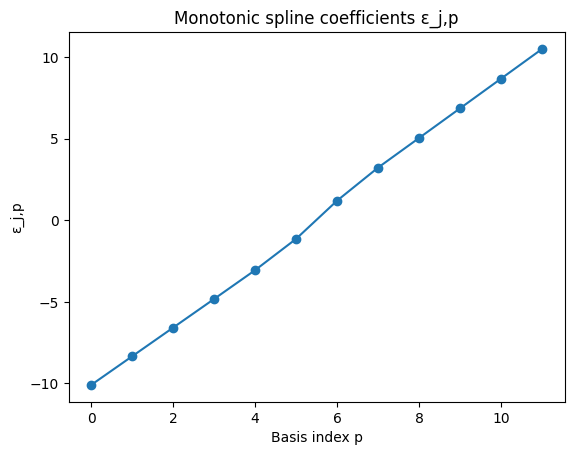

BAY
dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-9.9300, -8.1701, -6.2930, -4.4403, -2.6279, -0.8447,  0.9284,  2.6951,
         4.4655,  6.2325,  7.9957,  9.7558])


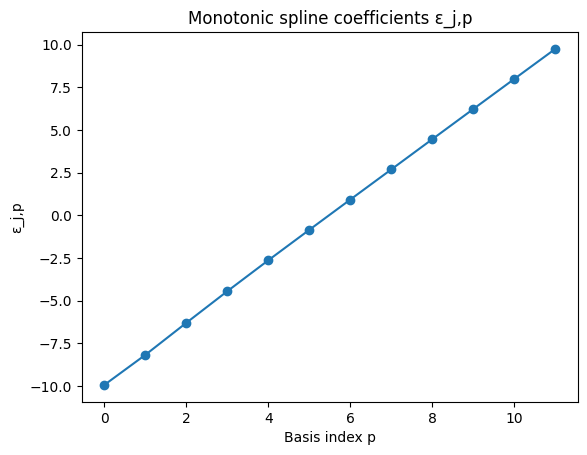

FREQ
dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-10.1053,  -8.3608,  -6.6163,  -4.8718,  -3.1195,  -1.1918,   1.0586,
          3.0809,   4.9073,   6.7254,   8.5436,  10.3618])


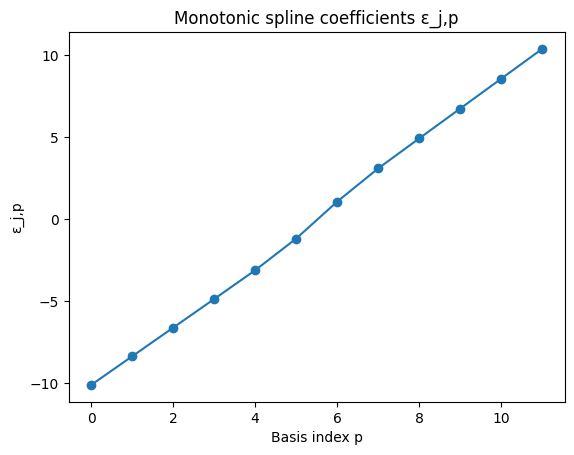

BAY
dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-9.9300, -8.1701, -6.2931, -4.4419, -2.6251, -0.8314,  0.9671,  2.7648,
         4.5572,  6.3389,  8.1069,  9.8677])


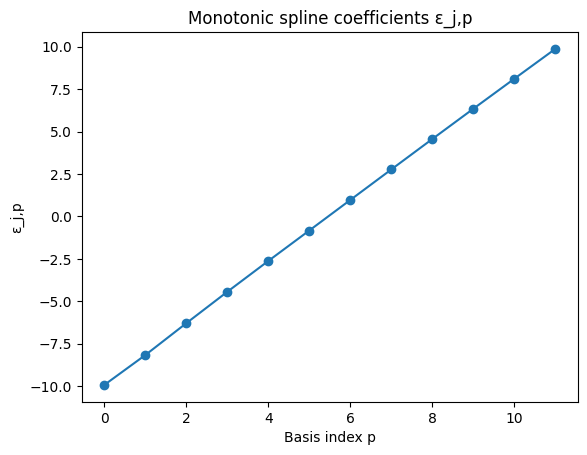

In [12]:
print("FREQ")
sanity_check(model_freq, transformation_grad=0)
print("BAY")
sanity_check(model, transformation_grad=0)
print("FREQ")
sanity_check(model_freq, transformation_grad=1)
print("BAY")
sanity_check(model, transformation_grad=1)

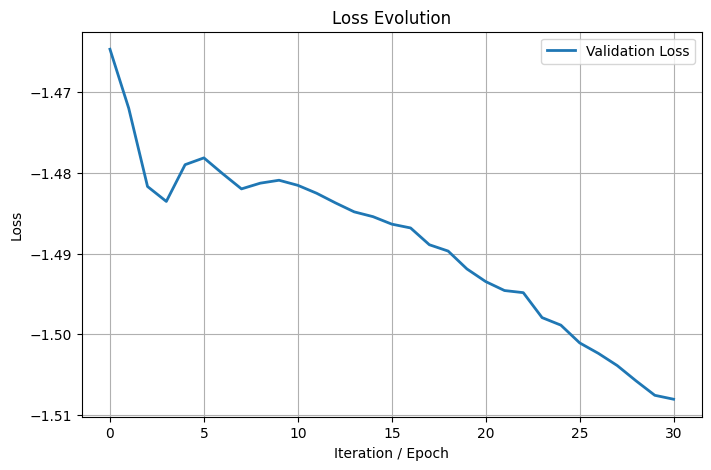

In [13]:
loss_history = output['loss_history']
val_loss = output['val_history']


# Plot            
plt.figure(figsize=(8, 5))
#plt.plot(loss_history, label="Loss", linewidth=2)
plt.plot(val_loss, label="Validation Loss", linewidth=2)
plt.xlabel("Iteration / Epoch")
plt.ylabel("Loss")
plt.title("Loss Evolution")
plt.legend()
plt.grid(True)
plt.show()

In [14]:
print(
    "freq_model nr. parameters", sum(p.numel() for p in model_freq.parameters() if p.requires_grad),
    "bay_model nr. parameters", sum(p.numel() for p in model.parameters() if p.requires_grad))

print("VI Model params = ",output['mu'])
print("BGTM params = ",[p for p in model.parameters() if p.requires_grad])
print("GTMp params = ",[p for p in model_freq.parameters() if p.requires_grad])

freq_model nr. parameters 24 bay_model nr. parameters 24
VI Model params =  tensor([-9.9300,  1.5710,  1.7110,  1.6821,  1.6342,  1.5991,  1.5870,  1.5793,
         1.5838,  1.5797,  1.5751,  1.5713, -9.9300,  1.5710,  1.7110,  1.6803,
         1.6394,  1.6118,  1.6175,  1.6165,  1.6102,  1.5974,  1.5809,  1.5721],
       device='cuda:0')
BGTM params =  [Parameter containing:
tensor([-9.9300,  1.5710,  1.7110,  1.6821,  1.6342,  1.5991,  1.5870,  1.5793,
         1.5838,  1.5797,  1.5751,  1.5713], device='cuda:0',
       requires_grad=True), Parameter containing:
tensor([-9.9300,  1.5710,  1.7110,  1.6803,  1.6394,  1.6118,  1.6175,  1.6165,
         1.6102,  1.5974,  1.5809,  1.5721], device='cuda:0',
       requires_grad=True)]
GTMp params =  [Parameter containing:
tensor([-10.0883,   1.5671,   1.5671,   1.5671,   1.5787,   1.7589,   2.2395,
          1.8834,   1.6372,   1.6411,   1.6411,   1.6411], requires_grad=True), Parameter containing:
tensor([-10.1053,   1.5525,   1.5525,   1

### 4. Compare to Benchmarks

We compare the learned GTM to a Gaussian Approximation and the Oracle Model. We expect the GTM to lie between these two in terms of approximation the true underlying distribution.
We measure this by means of the Kullback Leibler Divergence which we approximate on the test set which is equivalent to the log likelihood ratio between the true distribution and an approximation of it..

In [15]:
log_likelihood_train_bgtm = model.log_likelihood(simulated_data_train)
log_likelihood_validate_bgtm = model.log_likelihood(simulated_data_validate)
log_likelihood_test_bgtm = model.log_likelihood(simulated_data_test)


log_likelihood_train_gtm = model_freq.log_likelihood(simulated_data_train)
log_likelihood_validate_gtm = model_freq.log_likelihood(simulated_data_validate)
log_likelihood_test_gtm = model_freq.log_likelihood(simulated_data_test)

In [16]:
# estimate the Multivariate Normal Distribution as Model
mean_mvn_model = simulated_data_train.mean(0)
cov_mvn_model = simulated_data_train.T.cov()
mvn_model = torch.distributions.MultivariateNormal(loc=mean_mvn_model, covariance_matrix=cov_mvn_model)
log_likelihood_train_gaussian = mvn_model.log_prob(simulated_data_train)
log_likelihood_validate_gaussian = mvn_model.log_prob(simulated_data_validate)
log_likelihood_test_gaussian = mvn_model.log_prob(simulated_data_test)


In [17]:
print("KLD BGTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_bgtm).item(),4) )
print("KLD GTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm).item(),4) )
print("KLD Gaussian Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula   Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )
print("")
print("KLD BGTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_bgtm).item(),4) )
print("KLD GTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm).item(),4) )
print("KLD Gaussian Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula   Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD BGTM      Train Data:  0.0801
KLD GTM      Train Data:  0.0026
KLD Gaussian Train Data:  -0.0009
KLD Copula   Train Data:  -0.0001

KLD BGTM      Test  Data:  0.0883
KLD GTM      Test  Data:  0.0058
KLD Gaussian Test  Data:  0.001
KLD Copula   Test  Data:  0.0027


### 5. Evaluate and Plot GTM Results

We evaluate the model further by showing how to generate synthetic samples, plot the conditional correlation patterns as well as the model splines.

Note that to generate synthetic samples the inverse of the trainsformation layer needs to be approximated  with the method `approximate_transformation_inverse` once which is then stored for future sampling. 

In [18]:
model.approximate_transformation_inverse()
synthetic_samples = model.sample(10000)
model_freq.approximate_transformation_inverse()
synthetic_samples_freq = model_freq.sample(10000)

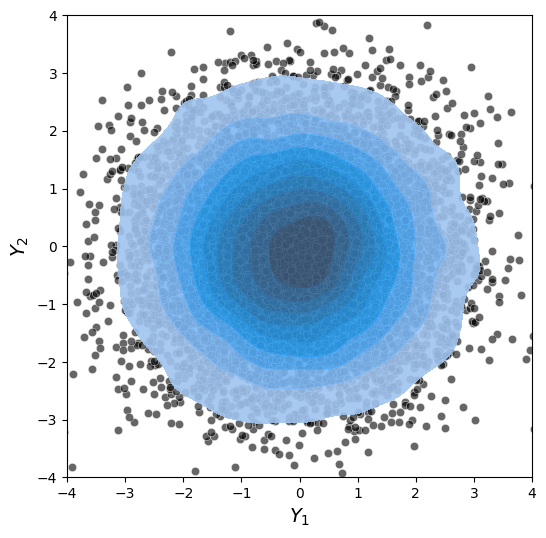

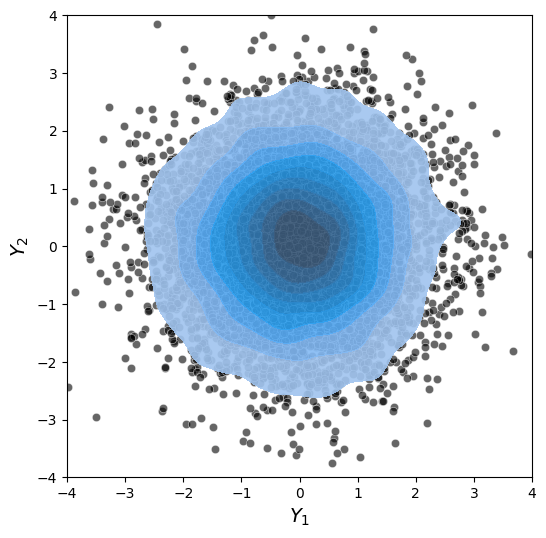

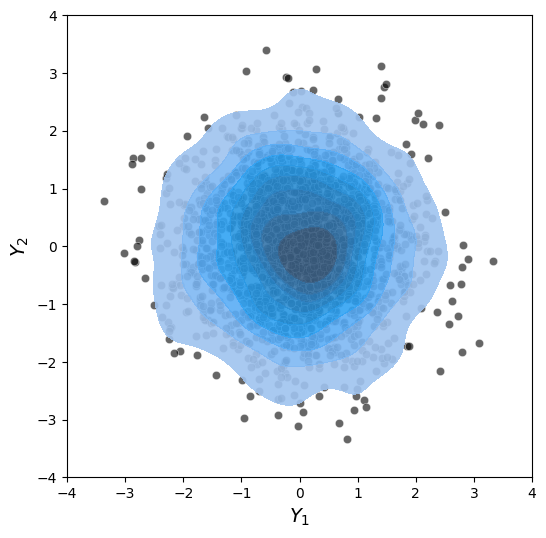

In [19]:
model.plot_densities(synthetic_samples.cpu().numpy(), x_lim=[-4,4], y_lim=[-4,4])
model_freq.plot_densities(synthetic_samples_freq, x_lim=[-4,4], y_lim=[-4,4])
model.plot_densities(simulated_data_train, x_lim=[-4,4], y_lim=[-4,4])

The varying pseudo conditional correlation matrix values can be computed for any synthetic samples using `compute_pseudo_conditional_correlation_matrix` or can directly be plotted using `plot_conditional_dependence_structure`.
The pseudo conditional correlation matrix is the standardised precision matrix so that off diagonal elements are the pseudo conditional correlations between the respective dimensions.

# Test 2
Independence copula + shifted/scaled Gaussian marginals (N(μ, σ²))

In [20]:
# User-chosen marginal parameters
mu = torch.tensor([1.5, -0.7], dtype=torch.float32)
sigma = torch.tensor([1.8, 0.6], dtype=torch.float32)  # stds

# ---------- Copula ----------
copula_pv = pv.Bicop(family=pv.BicopFamily.indep)

# ---------- Train ----------
N_train = 2000
simulated_data_uniform_train = copula_pv.simulate(n=N_train)
# Transform uniforms to shifted/scaled Gaussians
Z_train = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_train)).float()
simulated_data_train = mu + sigma * Z_train

# ---------- Validate ----------
N_validate = 2000
simulated_data_uniform_validate = copula_pv.simulate(n=N_validate)
Z_val = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_validate)).float()
simulated_data_validate = mu + sigma * Z_val

# ---------- Test ----------
N_test = 20000
simulated_data_uniform_test = copula_pv.simulate(n=N_test)
Z_test = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_test)).float()
simulated_data_test = mu + sigma * Z_test

# ---------- "True" log-likelihoods under independence + N(mu, sigma^2) ----------
loglik_true_train = torch.distributions.Normal(mu, sigma).log_prob(simulated_data_train).sum(1)
loglik_true_validate = torch.distributions.Normal(mu, sigma).log_prob(simulated_data_validate).sum(1)
loglik_true_test = torch.distributions.Normal(mu, sigma).log_prob(simulated_data_test).sum(1)

# ---------- "Estimated" marginals from train (fit μ, σ from train) ----------
means = simulated_data_train.mean(0)
stds  = simulated_data_train.std(0, unbiased=True)

loglik_true_est_train = torch.distributions.Normal(means, stds).log_prob(simulated_data_train).sum(1)
loglik_true_est_validate = torch.distributions.Normal(means, stds).log_prob(simulated_data_validate).sum(1)
loglik_true_est_test = torch.distributions.Normal(means, stds).log_prob(simulated_data_test).sum(1)

In [21]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train = DataLoader(dataset_train, batch_size=300)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate = DataLoader(dataset_validate, batch_size=300)

### BGTM model

In [22]:
model = GTM(
    number_variables=2,
    number_transformation_layers=1,
    number_decorrelation_layers=0,
    degree_transformations=10,
    degree_decorrelation=40,
    spline_transformation="bspline",
    spline_decorrelation="bspline",
    transformation_spline_range=(-10, 10),
    device="cuda" if torch.cuda.is_available() else "cpu",
    ## NEW ARGUMENTS ##
    inference = 'bayesian',
    hyperparameter=hyperparameters
    )

model.transform_only = True

output = model.pretrain_transformation_layer(
                train_dataloader=dataloader_train,
                validate_dataloader=dataloader_validate,
                hyperparameters=None,
                iterations=200,
                #verbose=True,
                learning_rate=0.01,
                mcmc_sample_train=32,            # will ramp
                mcmc_sample_val=128,             # fixed & larger for stable eval
                mc_ramp_every=60,               # 4→8→16→32 at epochs 25/50/75
                mc_ramp_max=64,
                patience=30,                # early-stop patience
                min_delta=0.0001,                # ~0.1% absolute of your loss scale
                rho_lr_multiplier=0.5,          # slightly faster variance adaption (optional)
                sched_factor=0.7, sched_patience=8, sched_threshold=1e-4,
            )

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


First 30 param keys: ['transformation.params.0', 'transformation.params.1']


  0%|          | 0/200 [00:00<?, ?it/s]

[sanity] N=2000  current B=300  (training objective uses scaled likelihood & unscaled prior)


  0%|          | 1/200 [00:10<35:02, 10.56s/it]

[1/200] train=20386.3376  val_ELPD=-1.9133  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0513 σmin=0.0488 σmax=0.0517  N=2000 B=200 B̄≈285.7  lik/obs≈14.78  priors/obs: decor≈0 trans≈2.03e+04  tau4=0.600831  rank=20  E_qf_mean≈18.5  E_qf_total≈36.9  tau*E_qf≈22.2  target≈22.2  resid≈-2.03e+04  Δ=-1.10e+03μ-nudge(±)≈-0.394


  1%|          | 2/200 [00:21<34:46, 10.54s/it]

[2/200] train=74.7898  val_ELPD=-1.7882  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0513 σmin=0.0488 σmax=0.0517  N=2000 B=200 B̄≈285.7  lik/obs≈13.87  priors/obs: decor≈0 trans≈23.6  tau4=0.618087  rank=20  E_qf_mean≈18  E_qf_total≈35.9  tau*E_qf≈22.2  target≈22.2  resid≈0.31  Δ=+1.73e-02μ-nudge(±)≈-14.8


  2%|▏         | 3/200 [00:31<34:34, 10.53s/it]

[3/200] train=74.0783  val_ELPD=-1.6785  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0513 σmin=0.0488 σmax=0.0517  N=2000 B=200 B̄≈285.7  lik/obs≈12.68  priors/obs: decor≈0 trans≈23.3  tau4=0.628556  rank=20  E_qf_mean≈17.7  E_qf_total≈35.3  tau*E_qf≈22.2  target≈22.2  resid≈0.185  Δ=+1.05e-02μ-nudge(±)≈8.28


  2%|▏         | 4/200 [00:42<34:38, 10.60s/it]

[4/200] train=72.4968  val_ELPD=-1.6295  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0513 σmin=0.0488 σmax=0.0517  N=2000 B=200 B̄≈285.7  lik/obs≈11.8  priors/obs: decor≈0 trans≈22.8  tau4=0.62935  rank=20  E_qf_mean≈17.4  E_qf_total≈34.9  tau*E_qf≈21.9  target≈22.2  resid≈0.138  Δ=+7.94e-04μ-nudge(±)≈2.51


  2%|▎         | 5/200 [00:52<34:22, 10.57s/it]

[5/200] train=70.9975  val_ELPD=-1.6118  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0513 σmin=0.0488 σmax=0.0517  N=2000 B=200 B̄≈285.7  lik/obs≈11.44  priors/obs: decor≈0 trans≈22  tau4=0.630987  rank=20  E_qf_mean≈17.2  E_qf_total≈34.4  tau*E_qf≈21.7  target≈22.2  resid≈0.281  Δ=+1.64e-03μ-nudge(±)≈3.48


  3%|▎         | 6/200 [01:03<34:07, 10.56s/it]

[6/200] train=69.9321  val_ELPD=-1.5999  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0513 σmin=0.0488 σmax=0.0517  N=2000 B=200 B̄≈285.7  lik/obs≈11.39  priors/obs: decor≈0 trans≈21.2  tau4=0.63372  rank=20  E_qf_mean≈16.9  E_qf_total≈33.7  tau*E_qf≈21.4  target≈22.2  resid≈0.461  Δ=+2.73e-03μ-nudge(±)≈1.8


  4%|▎         | 7/200 [01:13<33:53, 10.54s/it]

[7/200] train=69.2148  val_ELPD=-1.5870  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0527 σmin=0.0501 σmax=0.0532  N=2000 B=200 B̄≈285.7  lik/obs≈11.33  priors/obs: decor≈0 trans≈20.5  tau4=0.637744  rank=20  E_qf_mean≈16.5  E_qf_total≈32.9  tau*E_qf≈21  target≈22.2  resid≈0.663  Δ=+4.02e-03μ-nudge(±)≈-1.58


  4%|▍         | 8/200 [01:24<33:40, 10.52s/it]

[8/200] train=67.7527  val_ELPD=-1.5751  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0546 σmin=0.0519 σmax=0.0550  N=2000 B=200 B̄≈285.7  lik/obs≈11.22  priors/obs: decor≈0 trans≈19.9  tau4=0.643039  rank=20  E_qf_mean≈16.1  E_qf_total≈32.1  tau*E_qf≈20.7  target≈22.2  resid≈0.851  Δ=+5.29e-03μ-nudge(±)≈2.34


  4%|▍         | 9/200 [01:34<33:28, 10.52s/it]

[9/200] train=65.8885  val_ELPD=-1.5639  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0566 σmin=0.0538 σmax=0.0571  N=2000 B=200 B̄≈285.7  lik/obs≈11.1  priors/obs: decor≈0 trans≈19.2  tau4=0.656022  rank=20  E_qf_mean≈15.7  E_qf_total≈31.4  tau*E_qf≈20.6  target≈22.2  resid≈1.02  Δ=+1.30e-02μ-nudge(±)≈-2.11


  5%|▌         | 10/200 [01:45<33:17, 10.51s/it]

[10/200] train=64.8280  val_ELPD=-1.5545  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0587 σmin=0.0558 σmax=0.0592  N=2000 B=200 B̄≈285.7  lik/obs≈11.01  priors/obs: decor≈0 trans≈18.7  tau4=0.66999  rank=20  E_qf_mean≈15.3  E_qf_total≈30.6  tau*E_qf≈20.5  target≈22.2  resid≈1.07  Δ=+1.40e-02μ-nudge(±)≈-0.46


  6%|▌         | 11/200 [01:55<33:05, 10.51s/it]

[11/200] train=63.0413  val_ELPD=-1.5469  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0609 σmin=0.0579 σmax=0.0615  N=2000 B=200 B̄≈285.7  lik/obs≈10.94  priors/obs: decor≈0 trans≈18.2  tau4=0.684874  rank=20  E_qf_mean≈14.9  E_qf_total≈29.8  tau*E_qf≈20.4  target≈22.2  resid≈1.11  Δ=+1.49e-02μ-nudge(±)≈0.0251


  6%|▌         | 12/200 [02:06<32:54, 10.50s/it]

[12/200] train=61.4012  val_ELPD=-1.5403  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0632 σmin=0.0601 σmax=0.0637  N=2000 B=200 B̄≈285.7  lik/obs≈10.89  priors/obs: decor≈0 trans≈17.7  tau4=0.700649  rank=20  E_qf_mean≈14.5  E_qf_total≈29.1  tau*E_qf≈20.4  target≈22.2  resid≈1.15  Δ=+1.58e-02μ-nudge(±)≈-1.64


  6%|▋         | 13/200 [02:16<32:43, 10.50s/it]

[13/200] train=59.7972  val_ELPD=-1.5363  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0655 σmin=0.0623 σmax=0.0661  N=2000 B=200 B̄≈285.7  lik/obs≈10.85  priors/obs: decor≈0 trans≈17.1  tau4=0.717331  rank=20  E_qf_mean≈14.2  E_qf_total≈28.3  tau*E_qf≈20.3  target≈22.2  resid≈1.18  Δ=+1.67e-02μ-nudge(±)≈-0.297


  7%|▋         | 14/200 [02:27<32:31, 10.49s/it]

[14/200] train=58.1398  val_ELPD=-1.5326  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0679 σmin=0.0646 σmax=0.0685  N=2000 B=200 B̄≈285.7  lik/obs≈10.84  priors/obs: decor≈0 trans≈16.5  tau4=0.734952  rank=20  E_qf_mean≈13.8  E_qf_total≈27.6  tau*E_qf≈20.3  target≈22.2  resid≈1.21  Δ=+1.76e-02μ-nudge(±)≈-0.115


  8%|▊         | 15/200 [02:37<32:21, 10.49s/it]

[15/200] train=56.2973  val_ELPD=-1.5281  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0704 σmin=0.0669 σmax=0.0710  N=2000 B=200 B̄≈285.7  lik/obs≈10.81  priors/obs: decor≈0 trans≈15.9  tau4=0.753569  rank=20  E_qf_mean≈13.4  E_qf_total≈26.8  tau*E_qf≈20.2  target≈22.2  resid≈1.25  Δ=+1.86e-02μ-nudge(±)≈-0.303


  8%|▊         | 16/200 [02:48<32:10, 10.49s/it]

[16/200] train=55.4636  val_ELPD=-1.5268  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0729 σmin=0.0693 σmax=0.0735  N=2000 B=200 B̄≈285.7  lik/obs≈10.82  priors/obs: decor≈0 trans≈15.3  tau4=0.773271  rank=20  E_qf_mean≈13  E_qf_total≈26.1  tau*E_qf≈20.1  target≈22.2  resid≈1.28  Δ=+1.97e-02μ-nudge(±)≈4.48


  8%|▊         | 17/200 [02:58<31:59, 10.49s/it]

[17/200] train=54.4156  val_ELPD=-1.5236  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0754 σmin=0.0717 σmax=0.0761  N=2000 B=200 B̄≈285.7  lik/obs≈10.77  priors/obs: decor≈0 trans≈14.7  tau4=0.794089  rank=20  E_qf_mean≈12.7  E_qf_total≈25.3  tau*E_qf≈20.1  target≈22.2  resid≈1.32  Δ=+2.08e-02μ-nudge(±)≈-1.27


  9%|▉         | 18/200 [03:09<31:50, 10.50s/it]

[18/200] train=52.7656  val_ELPD=-1.5227  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0781 σmin=0.0742 σmax=0.0788  N=2000 B=200 B̄≈285.7  lik/obs≈10.77  priors/obs: decor≈0 trans≈14  tau4=0.816093  rank=20  E_qf_mean≈12.3  E_qf_total≈24.6  tau*E_qf≈20  target≈22.2  resid≈1.35  Δ=+2.20e-02μ-nudge(±)≈0.497


 10%|▉         | 19/200 [03:19<31:41, 10.50s/it]

[19/200] train=50.9312  val_ELPD=-1.5221  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0808 σmin=0.0768 σmax=0.0815  N=2000 B=200 B̄≈285.7  lik/obs≈10.78  priors/obs: decor≈0 trans≈13.4  tau4=0.839324  rank=20  E_qf_mean≈11.9  E_qf_total≈23.8  tau*E_qf≈20  target≈22.2  resid≈1.38  Δ=+2.32e-02μ-nudge(±)≈0.0423


 10%|█         | 20/200 [03:30<31:31, 10.51s/it]

[20/200] train=49.4036  val_ELPD=-1.5224  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0836 σmin=0.0795 σmax=0.0843  N=2000 B=200 B̄≈285.7  lik/obs≈10.78  priors/obs: decor≈0 trans≈12.7  tau4=0.86382  rank=20  E_qf_mean≈11.5  E_qf_total≈23.1  tau*E_qf≈19.9  target≈22.2  resid≈1.41  Δ=+2.45e-02μ-nudge(±)≈-2.75


 10%|█         | 21/200 [03:40<31:20, 10.50s/it]

[21/200] train=48.4765  val_ELPD=-1.5230  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0864 σmin=0.0822 σmax=0.0872  N=2000 B=200 B̄≈285.7  lik/obs≈10.78  priors/obs: decor≈0 trans≈12  tau4=0.88972  rank=20  E_qf_mean≈11.2  E_qf_total≈22.3  tau*E_qf≈19.9  target≈22.2  resid≈1.45  Δ=+2.59e-02μ-nudge(±)≈-4.32


 11%|█         | 22/200 [03:51<31:09, 10.50s/it]

[22/200] train=46.2501  val_ELPD=-1.5239  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0894 σmin=0.0850 σmax=0.0902  N=2000 B=200 B̄≈285.7  lik/obs≈10.79  priors/obs: decor≈0 trans≈11.3  tau4=0.916995  rank=20  E_qf_mean≈10.8  E_qf_total≈21.6  tau*E_qf≈19.8  target≈22.2  resid≈1.48  Δ=+2.73e-02μ-nudge(±)≈-1.24


 12%|█▏        | 23/200 [04:01<30:55, 10.49s/it]

[23/200] train=45.0404  val_ELPD=-1.5244  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0924 σmin=0.0878 σmax=0.0932  N=2000 B=200 B̄≈285.7  lik/obs≈10.8  priors/obs: decor≈0 trans≈10.6  tau4=0.94579  rank=20  E_qf_mean≈10.5  E_qf_total≈20.9  tau*E_qf≈19.8  target≈22.2  resid≈1.51  Δ=+2.88e-02μ-nudge(±)≈4.52


 12%|█▏        | 24/200 [04:12<30:42, 10.47s/it]

[24/200] train=43.6132  val_ELPD=-1.5265  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0955 σmin=0.0908 σmax=0.0964  N=2000 B=200 B̄≈285.7  lik/obs≈10.83  priors/obs: decor≈0 trans≈9.85  tau4=0.976173  rank=20  E_qf_mean≈10.1  E_qf_total≈20.2  tau*E_qf≈19.7  target≈22.2  resid≈1.54  Δ=+3.04e-02μ-nudge(±)≈-1.25


 12%|█▎        | 25/200 [04:22<30:28, 10.45s/it]

[25/200] train=42.3719  val_ELPD=-1.5289  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0987 σmin=0.0938 σmax=0.0996  N=2000 B=200 B̄≈285.7  lik/obs≈10.86  priors/obs: decor≈0 trans≈9.1  tau4=1.00828  rank=20  E_qf_mean≈9.76  E_qf_total≈19.5  tau*E_qf≈19.7  target≈22.2  resid≈1.57  Δ=+3.21e-02μ-nudge(±)≈-1.48


 13%|█▎        | 26/200 [04:33<30:15, 10.44s/it]

[26/200] train=40.8284  val_ELPD=-1.5324  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.1019 σmin=0.0969 σmax=0.1029  N=2000 B=200 B̄≈285.7  lik/obs≈10.87  priors/obs: decor≈0 trans≈8.35  tau4=1.04203  rank=20  E_qf_mean≈9.43  E_qf_total≈18.9  tau*E_qf≈19.7  target≈22.2  resid≈1.59  Δ=+3.38e-02μ-nudge(±)≈-0.967


 14%|█▎        | 27/200 [04:43<30:04, 10.43s/it]

[27/200] train=39.0213  val_ELPD=-1.5350  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.1053 σmin=0.1000 σmax=0.1063  N=2000 B=200 B̄≈285.7  lik/obs≈10.89  priors/obs: decor≈0 trans≈7.58  tau4=1.07772  rank=20  E_qf_mean≈9.09  E_qf_total≈18.2  tau*E_qf≈19.6  target≈22.2  resid≈1.62  Δ=+3.57e-02μ-nudge(±)≈-1.84


 14%|█▍        | 28/200 [04:53<29:50, 10.41s/it]

[28/200] train=37.5029  val_ELPD=-1.5388  S_train=32 S_val=128  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.1087 σmin=0.1033 σmax=0.1098  N=2000 B=200 B̄≈285.7  lik/obs≈10.94  priors/obs: decor≈0 trans≈6.81  tau4=1.11538  rank=20  E_qf_mean≈8.77  E_qf_total≈17.5  tau*E_qf≈19.6  target≈22.2  resid≈1.65  Δ=+3.77e-02μ-nudge(±)≈-1.22


 14%|█▍        | 29/200 [05:04<29:39, 10.41s/it]

[29/200] train=36.2578  val_ELPD=-1.5389  S_train=32 S_val=128  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.1112 σmin=0.1056 σmax=0.1123  N=2000 B=200 B̄≈285.7  lik/obs≈11  priors/obs: decor≈0 trans≈6.17  tau4=1.15384  rank=20  E_qf_mean≈8.49  E_qf_total≈17  tau*E_qf≈19.6  target≈22.2  resid≈1.63  Δ=+3.85e-02μ-nudge(±)≈-3.3


 15%|█▌        | 30/200 [05:14<29:27, 10.40s/it]

[30/200] train=35.7041  val_ELPD=-1.5416  S_train=32 S_val=128  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.1136 σmin=0.1080 σmax=0.1148  N=2000 B=200 B̄≈285.7  lik/obs≈11  priors/obs: decor≈0 trans≈5.71  tau4=1.19173  rank=20  E_qf_mean≈8.26  E_qf_total≈16.5  tau*E_qf≈19.7  target≈22.2  resid≈1.57  Δ=+3.79e-02μ-nudge(±)≈2.18


 16%|█▌        | 31/200 [05:24<29:17, 10.40s/it]

[31/200] train=34.5000  val_ELPD=-1.5436  S_train=32 S_val=128  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.1162 σmin=0.1104 σmax=0.1174  N=2000 B=200 B̄≈285.7  lik/obs≈11.02  priors/obs: decor≈0 trans≈5.22  tau4=1.22957  rank=20  E_qf_mean≈8.04  E_qf_total≈16.1  tau*E_qf≈19.8  target≈22.2  resid≈1.52  Δ=+3.78e-02μ-nudge(±)≈-3.73


 16%|█▌        | 32/200 [05:35<29:06, 10.40s/it]

[32/200] train=32.7003  val_ELPD=-1.5499  S_train=32 S_val=128  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.1188 σmin=0.1128 σmax=0.1200  N=2000 B=200 B̄≈285.7  lik/obs≈11.06  priors/obs: decor≈0 trans≈4.71  tau4=1.2676  rank=20  E_qf_mean≈7.82  E_qf_total≈15.6  tau*E_qf≈19.8  target≈22.2  resid≈1.49  Δ=+3.80e-02μ-nudge(±)≈-1.92


 16%|█▋        | 33/200 [05:45<28:59, 10.42s/it]

[33/200] train=32.1911  val_ELPD=-1.5514  S_train=32 S_val=128  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.1214 σmin=0.1153 σmax=0.1227  N=2000 B=200 B̄≈285.7  lik/obs≈11.09  priors/obs: decor≈0 trans≈4.2  tau4=1.30624  rank=20  E_qf_mean≈7.6  E_qf_total≈15.2  tau*E_qf≈19.8  target≈22.2  resid≈1.47  Δ=+3.86e-02μ-nudge(±)≈6.33


 17%|█▋        | 34/200 [05:56<28:51, 10.43s/it]

[34/200] train=31.2023  val_ELPD=-1.5578  S_train=32 S_val=128  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.1240 σmin=0.1178 σmax=0.1254  N=2000 B=200 B̄≈285.7  lik/obs≈11.14  priors/obs: decor≈0 trans≈3.66  tau4=1.34592  rank=20  E_qf_mean≈7.38  E_qf_total≈14.8  tau*E_qf≈19.9  target≈22.2  resid≈1.46  Δ=+3.97e-02μ-nudge(±)≈4.73


 18%|█▊        | 35/200 [06:06<28:41, 10.43s/it]

[35/200] train=29.8959  val_ELPD=-1.5598  S_train=32 S_val=128  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.1268 σmin=0.1203 σmax=0.1282  N=2000 B=200 B̄≈285.7  lik/obs≈11.18  priors/obs: decor≈0 trans≈3.14  tau4=1.38649  rank=20  E_qf_mean≈7.17  E_qf_total≈14.3  tau*E_qf≈19.9  target≈22.2  resid≈1.45  Δ=+4.06e-02μ-nudge(±)≈2.25


 18%|█▊        | 36/200 [06:17<28:30, 10.43s/it]

[36/200] train=29.5251  val_ELPD=-1.5618  S_train=32 S_val=128  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.1295 σmin=0.1229 σmax=0.1310  N=2000 B=200 B̄≈285.7  lik/obs≈11.22  priors/obs: decor≈0 trans≈2.58  tau4=1.42883  rank=20  E_qf_mean≈6.94  E_qf_total≈13.9  tau*E_qf≈19.8  target≈22.2  resid≈1.47  Δ=+4.23e-02μ-nudge(±)≈-3.32


 18%|█▊        | 37/200 [06:27<28:18, 10.42s/it]

[37/200] train=28.0417  val_ELPD=-1.5688  S_train=32 S_val=128  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.1323 σmin=0.1256 σmax=0.1339  N=2000 B=200 B̄≈285.7  lik/obs≈11.26  priors/obs: decor≈0 trans≈2.03  tau4=1.4728  rank=20  E_qf_mean≈6.73  E_qf_total≈13.5  tau*E_qf≈19.8  target≈22.2  resid≈1.48  Δ=+4.40e-02μ-nudge(±)≈9.31


 19%|█▉        | 38/200 [06:37<28:07, 10.42s/it]

[38/200] train=26.7037  val_ELPD=-1.5725  S_train=32 S_val=128  lr=[0.004899999999999999, 0.0024499999999999995]  σ̄=0.1352 σmin=0.1283 σmax=0.1368  N=2000 B=200 B̄≈285.7  lik/obs≈11.31  priors/obs: decor≈0 trans≈1.48  tau4=1.51848  rank=20  E_qf_mean≈6.52  E_qf_total≈13  tau*E_qf≈19.8  target≈22.2  resid≈1.49  Δ=+4.57e-02μ-nudge(±)≈4.09


 20%|█▉        | 39/200 [06:48<27:57, 10.42s/it]

[39/200] train=25.5771  val_ELPD=-1.5699  S_train=32 S_val=128  lr=[0.004899999999999999, 0.0024499999999999995]  σ̄=0.1372 σmin=0.1302 σmax=0.1389  N=2000 B=200 B̄≈285.7  lik/obs≈11.36  priors/obs: decor≈0 trans≈1.03  tau4=1.56488  rank=20  E_qf_mean≈6.34  E_qf_total≈12.7  tau*E_qf≈19.8  target≈22.2  resid≈1.47  Δ=+4.64e-02μ-nudge(±)≈1.51


 20%|██        | 40/200 [06:58<27:46, 10.42s/it]

[40/200] train=25.4987  val_ELPD=-1.5751  S_train=32 S_val=128  lr=[0.004899999999999999, 0.0024499999999999995]  σ̄=0.1393 σmin=0.1321 σmax=0.1410  N=2000 B=200 B̄≈285.7  lik/obs≈11.35  priors/obs: decor≈0 trans≈0.714  tau4=1.61023  rank=20  E_qf_mean≈6.19  E_qf_total≈12.4  tau*E_qf≈19.9  target≈22.2  resid≈1.4  Δ=+4.54e-02μ-nudge(±)≈-1.51


 20%|██        | 41/200 [07:09<27:35, 10.41s/it]

[41/200] train=24.8084  val_ELPD=-1.5790  S_train=32 S_val=128  lr=[0.004899999999999999, 0.0024499999999999995]  σ̄=0.1414 σmin=0.1341 σmax=0.1431  N=2000 B=200 B̄≈285.7  lik/obs≈11.37  priors/obs: decor≈0 trans≈0.382  tau4=1.65521  rank=20  E_qf_mean≈6.05  E_qf_total≈12.1  tau*E_qf≈20  target≈22.2  resid≈1.36  Δ=+4.50e-02μ-nudge(±)≈-1.1


 21%|██        | 42/200 [07:19<27:24, 10.41s/it]

[42/200] train=24.5514  val_ELPD=-1.5846  S_train=32 S_val=128  lr=[0.004899999999999999, 0.0024499999999999995]  σ̄=0.1435 σmin=0.1360 σmax=0.1453  N=2000 B=200 B̄≈285.7  lik/obs≈11.44  priors/obs: decor≈0 trans≈0.0169  tau4=1.70109  rank=20  E_qf_mean≈5.89  E_qf_total≈11.8  tau*E_qf≈20  target≈22.2  resid≈1.35  Δ=+4.59e-02μ-nudge(±)≈7.15


 22%|██▏       | 43/200 [07:30<27:14, 10.41s/it]

[43/200] train=23.6629  val_ELPD=-1.5870  S_train=32 S_val=128  lr=[0.004899999999999999, 0.0024499999999999995]  σ̄=0.1456 σmin=0.1380 σmax=0.1475  N=2000 B=200 B̄≈285.7  lik/obs≈11.46  priors/obs: decor≈0 trans≈-0.312  tau4=1.7464  rank=20  E_qf_mean≈5.76  E_qf_total≈11.5  tau*E_qf≈20.1  target≈22.2  resid≈1.3  Δ=+4.53e-02μ-nudge(±)≈-3.44


 22%|██▏       | 44/200 [07:40<27:04, 10.41s/it]

[44/200] train=23.0597  val_ELPD=-1.5849  S_train=32 S_val=128  lr=[0.004899999999999999, 0.0024499999999999995]  σ̄=0.1477 σmin=0.1401 σmax=0.1497  N=2000 B=200 B̄≈285.7  lik/obs≈11.46  priors/obs: decor≈0 trans≈-0.692  tau4=1.79317  rank=20  E_qf_mean≈5.6  E_qf_total≈11.2  tau*E_qf≈20.1  target≈22.2  resid≈1.31  Δ=+4.68e-02μ-nudge(±)≈-3.64


 22%|██▎       | 45/200 [07:50<26:56, 10.43s/it]

[45/200] train=22.1662  val_ELPD=-1.5892  S_train=32 S_val=128  lr=[0.004899999999999999, 0.0024499999999999995]  σ̄=0.1499 σmin=0.1421 σmax=0.1519  N=2000 B=200 B̄≈285.7  lik/obs≈11.5  priors/obs: decor≈0 trans≈-1.05  tau4=1.84075  rank=20  E_qf_mean≈5.46  E_qf_total≈10.9  tau*E_qf≈20.1  target≈22.2  resid≈1.3  Δ=+4.76e-02μ-nudge(±)≈-5.74


 23%|██▎       | 46/200 [08:01<26:45, 10.43s/it]

[46/200] train=21.6031  val_ELPD=-1.5959  S_train=32 S_val=128  lr=[0.004899999999999999, 0.0024499999999999995]  σ̄=0.1521 σmin=0.1442 σmax=0.1542  N=2000 B=200 B̄≈285.7  lik/obs≈11.64  priors/obs: decor≈0 trans≈-1.43  tau4=1.88948  rank=20  E_qf_mean≈5.32  E_qf_total≈10.6  tau*E_qf≈20.1  target≈22.2  resid≈1.3  Δ=+4.87e-02μ-nudge(±)≈-2.79


 24%|██▎       | 47/200 [08:11<26:35, 10.43s/it]

[47/200] train=20.4277  val_ELPD=-1.5989  S_train=32 S_val=128  lr=[0.004899999999999999, 0.0024499999999999995]  σ̄=0.1543 σmin=0.1463 σmax=0.1565  N=2000 B=200 B̄≈285.7  lik/obs≈11.65  priors/obs: decor≈0 trans≈-1.81  tau4=1.93995  rank=20  E_qf_mean≈5.18  E_qf_total≈10.4  tau*E_qf≈20.1  target≈22.2  resid≈1.31  Δ=+5.05e-02μ-nudge(±)≈2.04


 24%|██▍       | 48/200 [08:22<26:25, 10.43s/it]

[48/200] train=20.1981  val_ELPD=-1.6033  S_train=32 S_val=128  lr=[0.003429999999999999, 0.0017149999999999995]  σ̄=0.1566 σmin=0.1484 σmax=0.1588  N=2000 B=200 B̄≈285.7  lik/obs≈11.67  priors/obs: decor≈0 trans≈-2.23  tau4=1.99346  rank=20  E_qf_mean≈5.03  E_qf_total≈10.1  tau*E_qf≈20  target≈22.2  resid≈1.35  Δ=+5.35e-02μ-nudge(±)≈18.6


 24%|██▍       | 48/200 [08:32<27:03, 10.68s/it]

[49/200] train=19.8749  val_ELPD=-1.6028  S_train=32 S_val=128  lr=[0.003429999999999999, 0.0017149999999999995]  σ̄=0.1582 σmin=0.1499 σmax=0.1605  N=2000 B=200 B̄≈285.7  lik/obs≈11.73  priors/obs: decor≈0 trans≈-2.52  tau4=2.0469  rank=20  E_qf_mean≈4.91  E_qf_total≈9.82  tau*E_qf≈20.1  target≈22.2  resid≈1.31  Δ=+5.34e-02μ-nudge(±)≈-5.08
Early stop @ epoch 49: no val improvement for 30 epochs.


### GTM model

In [23]:

model_freq = GTM(
    number_variables = 2,
    number_transformation_layers = 1,
    number_decorrelation_layers = 0,
    degree_transformations = 10,
    degree_decorrelation = 40,
    spline_transformation = "bspline",
    spline_decorrelation = "bspline",
    transformation_spline_range = (-10, 10),
    device = "cpu") 

penalty_splines_params=torch.FloatTensor([
                            0, #study.best_params["penalty_decorrelation_ridge_param"],
                            0,
                            0,
                            0 #study.best_params["penalty_transformation_ridge_second_difference"]
                              ])
adaptive_lasso_weights_matrix = False
penalty_lasso_conditional_independence=False

# pretrain the marginal transformations
output_freq = model_freq.pretrain_transformation_layer(dataloader_train, iterations=1000, max_batches_per_iter=False, penalty_splines_params=penalty_splines_params)

  0%|          | 1/1000 [00:00<02:22,  7.01it/s]

current_loss: tensor(2.1995, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8699, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8426, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6451, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6802, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6691, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6503, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6203, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6701, grad_fn=<MeanBackward0>)
current_loss: tensor(37.4469, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6151, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6051, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5176, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4483, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4498, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4349, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5146, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5082, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4942

  0%|          | 2/1000 [00:00<02:14,  7.41it/s]

current_loss: tensor(1.5159, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5037, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5035, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4998, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5009, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4983, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4316, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4296, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4985, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4979, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4805, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4794, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5171, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4984, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4982, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4968, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4978, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4940,

  0%|          | 3/1000 [00:00<02:15,  7.37it/s]

current_loss: tensor(1.4803, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4079, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3986, grad_fn=<MeanBackward0>)


  0%|          | 4/1000 [00:00<02:18,  7.19it/s]

current_loss: tensor(1.4878, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4881, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4747, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4544, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4507, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5046, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5242, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5014, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4809, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4767, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4821, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4834, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4797, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4819, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4797, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3890, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3872, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4735, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4730,

  0%|          | 5/1000 [00:00<02:17,  7.24it/s]

current_loss: tensor(1.4774, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4760, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4790, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4779, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4788, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4782, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3884, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3876, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3823, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4711, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4705, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4512, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4498, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5024, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4962, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4783, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4759, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4774, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4764,

  1%|          | 6/1000 [00:00<02:13,  7.43it/s]

current_loss: tensor(1.3875, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3866, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3810, grad_fn=<MeanBackward0>)


  1%|          | 7/1000 [00:00<02:11,  7.56it/s]

current_loss: tensor(1.4713, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4702, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4514, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4497, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5021, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4960, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4774, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4754, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4763, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4755, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4776, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4770, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3871, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3862, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3805, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4706, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4695, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4512, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4494,

  1%|          | 9/1000 [00:01<02:08,  7.71it/s]

current_loss: tensor(1.4746, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4770, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4764, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3868, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3858, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3801, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4701, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4689, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4510, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4491, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5014, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4952, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4773, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4751, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4747, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4738, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4765, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4758, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3865,

  1%|          | 10/1000 [00:01<02:07,  7.75it/s]

current_loss: tensor(1.4488, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5011, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4948, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4773, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4750, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4740, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4731, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4760, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4753, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3863, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3853, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3816, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4680, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4675, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4496, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4485, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5033, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5012, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4735,

  1%|          | 12/1000 [00:01<02:14,  7.37it/s]

current_loss: tensor(1.3846, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3843, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3833, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4664, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4664, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4661, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4483, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4481, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5021, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5156, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5013, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4740, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4730, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4730, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4848, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4723, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4768, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4753, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3842,

  1%|▏         | 13/1000 [00:01<02:14,  7.36it/s]

current_loss: tensor(1.4558, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4469, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4972, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5077, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4950, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4797, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4754, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4732, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4718, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4788, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4733, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3865, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3834, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4672, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4664, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4483, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4472, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4994, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4979,

  2%|▏         | 15/1000 [00:01<02:10,  7.56it/s]

current_loss: tensor(1.4737, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3846, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3824, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4654, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4652, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4480, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4477, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5006, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5002, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4983, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4741, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4730, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4708, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4998, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4700, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4751, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4735, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3845, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3832,

  2%|▏         | 16/1000 [00:02<02:11,  7.50it/s]

current_loss: tensor(1.4999, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4953, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4742, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4735, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4701, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4697, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4727, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4725, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4715, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3908, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3867, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4654, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4646, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4469, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4468, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4978, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4976, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4968, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4748,

  2%|▏         | 16/1000 [00:02<02:19,  7.05it/s]

current_loss: tensor(1.4725, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3854, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3840, grad_fn=<MeanBackward0>)
Early Stop at iteration 16 with minimal loss tensor(1.3842, grad_fn=<MeanBackward0>) and patience 5 and min_delta 1e-07


dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-10.0420,  -8.2555,  -6.4689,  -4.6821,  -2.9417,  -1.3867,  -0.0350,
          1.1856,   2.5077,   4.1848,   6.0043,   7.8225])


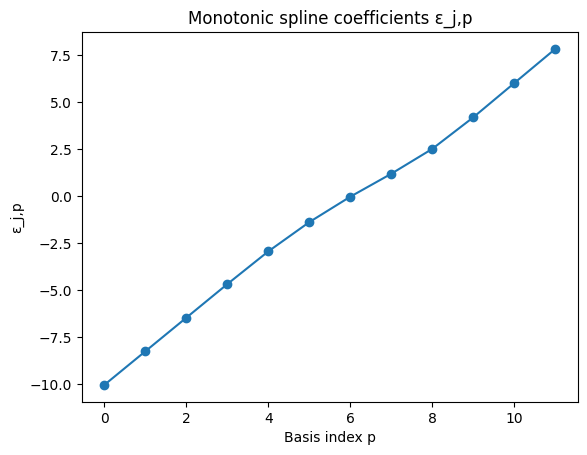

dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-9.0644, -8.0210, -5.9456, -4.3826, -2.9253, -1.5105, -0.2349,  0.8538,
         1.7550,  2.5479,  3.3178,  4.0854])


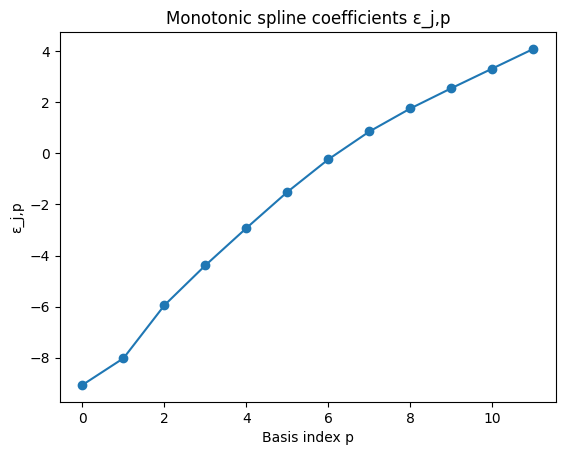

dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-10.2852,  -8.6619,  -7.0385,  -5.4152,  -3.7725,  -0.8432,   3.0704,
          5.0377,   6.8559,   8.6741,  10.4923,  12.3104])


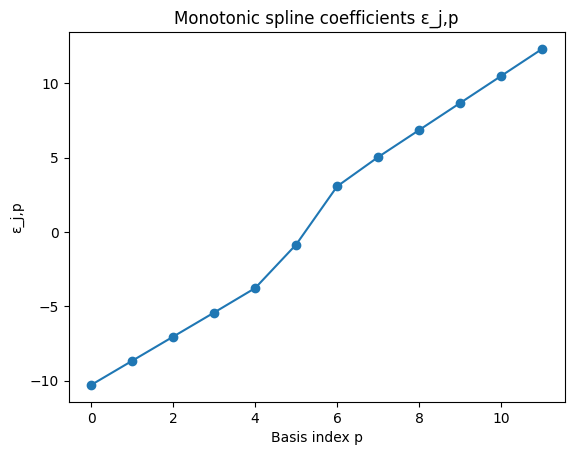

dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-8.8501, -7.9217, -5.5584, -4.3632, -3.1937, -0.5803,  2.0711,  2.9333,
         3.7095,  4.4894,  5.2639,  6.0320])


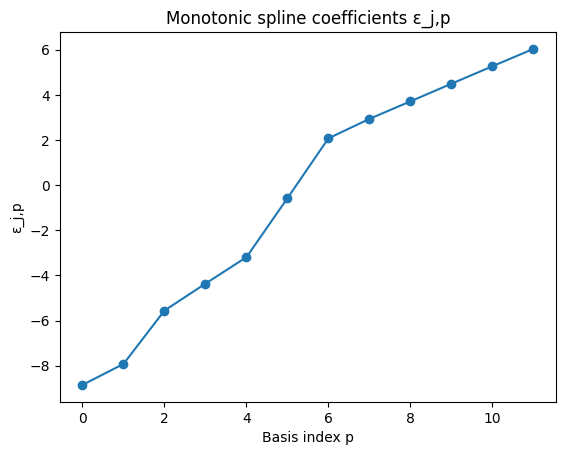

In [24]:
sanity_check(model_freq, transformation_grad=0)
sanity_check(model, transformation_grad=0)
sanity_check(model_freq, transformation_grad=1)
sanity_check(model, transformation_grad=1)

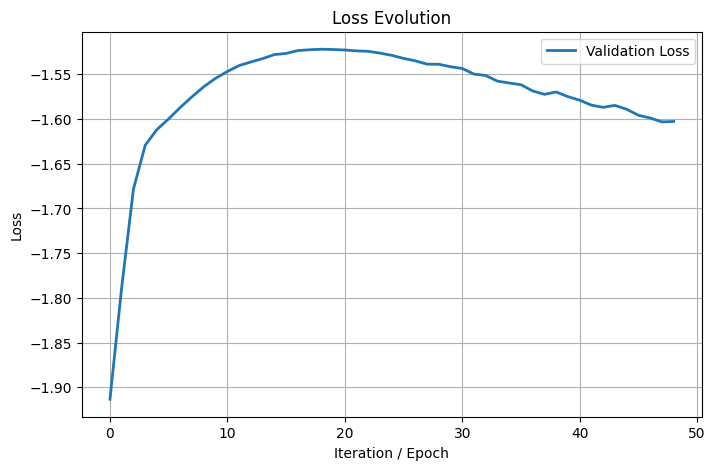

In [25]:
loss_history = output['loss_history']
val_loss = output['val_history']


# Plot            
plt.figure(figsize=(8, 5))
#plt.plot(loss_history, label="Loss", linewidth=2)
plt.plot(val_loss, label="Validation Loss", linewidth=2)
plt.xlabel("Iteration / Epoch")
plt.ylabel("Loss")
plt.title("Loss Evolution")
plt.legend()
plt.grid(True)
plt.show()

In [26]:
log_likelihood_train_bgtm = model.log_likelihood(simulated_data_train)
log_likelihood_validate_bgtm = model.log_likelihood(simulated_data_validate)
log_likelihood_test_bgtm = model.log_likelihood(simulated_data_test)


log_likelihood_train_gtm = model_freq.log_likelihood(simulated_data_train)
log_likelihood_validate_gtm = model_freq.log_likelihood(simulated_data_validate)
log_likelihood_test_gtm = model_freq.log_likelihood(simulated_data_test)

In [27]:
# estimate the Multivariate Normal Distribution as Model
mean_mvn_model = simulated_data_train.mean(0)
cov_mvn_model = simulated_data_train.T.cov()
mvn_model = torch.distributions.MultivariateNormal(loc=mean_mvn_model, covariance_matrix=cov_mvn_model)
log_likelihood_train_gaussian = mvn_model.log_prob(simulated_data_train)
log_likelihood_validate_gaussian = mvn_model.log_prob(simulated_data_validate)
log_likelihood_test_gaussian = mvn_model.log_prob(simulated_data_test)


In [28]:
print("KLD BGTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_bgtm).item(),4) )
print("KLD GTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm).item(),4) )
print("KLD Gaussian Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula   Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )
print("")
print("KLD BGTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_bgtm).item(),4) )
print("KLD GTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm).item(),4) )
print("KLD Gaussian Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula   Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD BGTM      Train Data:  0.138
KLD GTM      Train Data:  0.0241
KLD Gaussian Train Data:  -0.0002
KLD Copula   Train Data:  -0.0001

KLD BGTM      Test  Data:  0.14
KLD GTM      Test  Data:  0.0236
KLD Gaussian Test  Data:  0.0
KLD Copula   Test  Data:  0.0001


In [29]:
#model.approximate_transformation_inverse()
synthetic_samples = model.sample(10000)
model_freq.approximate_transformation_inverse()
synthetic_samples_freq = model_freq.sample(10000)

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_model/gtm.py:1262: UserWarning: Transformation layer does not have an inverse. Inverse is approximated
  warnings.warn(


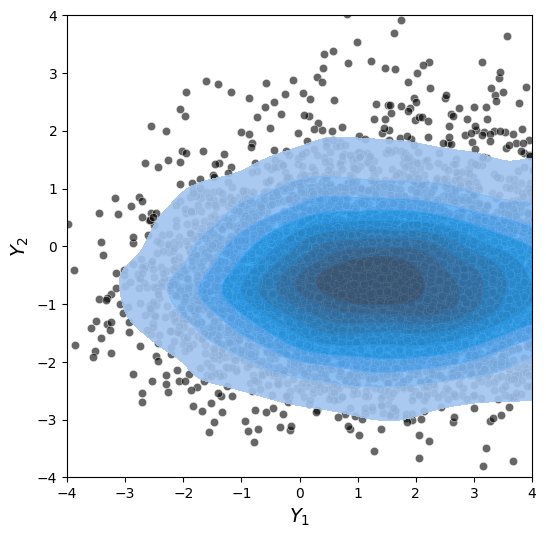

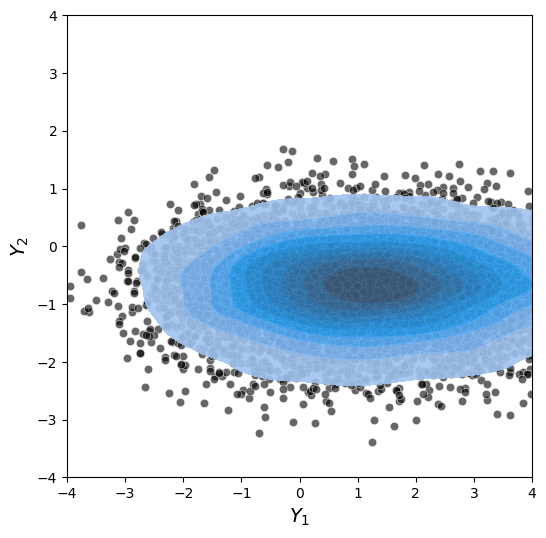

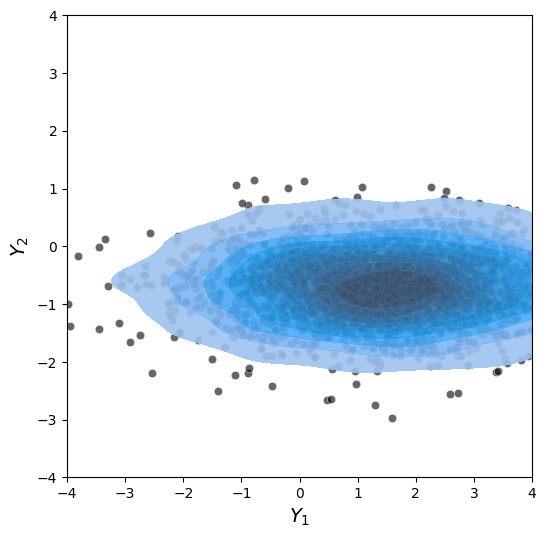

In [30]:
model.plot_densities(synthetic_samples.cpu().numpy(), x_lim=[-4,4], y_lim=[-4,4])
model_freq.plot_densities(synthetic_samples_freq, x_lim=[-4,4], y_lim=[-4,4])
model.plot_densities(simulated_data_train, x_lim=[-4,4], y_lim=[-4,4])

### Independence copula + two-component Gaussian mixture marginals (non-Gaussian)

In [31]:
import numpy as np
import torch
import pyvinecopulib as pv

# Mixture parameters per dimension (same weights across dims for simplicity)
w1 = 0.35  # w2 = 1 - w1
means = torch.tensor([[-2.0,  1.0],   # component 1 means per dim
                      [ 2.0, -1.0]],  # component 2 means per dim
                     dtype=torch.float32)
stds  = torch.tensor([[0.8, 0.5],
                      [0.6, 0.9]], dtype=torch.float32)

def gm2_icdf(u, w1, m, s):
    """
    u: [N, D] tensor in (0,1); w1 scalar; m,s: shape [2, D]
    Returns x: [N, D]
    """
    w2 = 1.0 - w1
    x = torch.empty_like(u)
    mask1 = (u < w1)
    u1 = torch.where(mask1, u / w1, torch.tensor(0.5, dtype=u.dtype))
    u2 = torch.where(~mask1, (u - w1) / w2, torch.tensor(0.5, dtype=u.dtype))
    # invert per dim
    for d in range(u.shape[1]):
        x1 = torch.distributions.Normal(m[0, d], s[0, d]).icdf(u1[:, d])
        x2 = torch.distributions.Normal(m[1, d], s[1, d]).icdf(u2[:, d])
        x[:, d] = torch.where(mask1[:, d], x1, x2)
    return x

def gm2_logpdf(x, w1, m, s):
    w2 = 1.0 - w1
    lp = torch.zeros(x.shape[0])
    for d in range(x.shape[1]):
        lp1 = torch.distributions.Normal(m[0, d], s[0, d]).log_prob(x[:, d])
        lp2 = torch.distributions.Normal(m[1, d], s[1, d]).log_prob(x[:, d])
        # log( w1*e^lp1 + w2*e^lp2 )
        a = torch.stack([lp1 + np.log(w1), lp2 + np.log(w2)], dim=1)
        lp += torch.logsumexp(a, dim=1)
    return lp

# ---------- Copula ----------
copula_pv = pv.Bicop(family=pv.BicopFamily.indep)

# ---------- Train ----------
N_train = 2000
simulated_data_uniform_train = copula_pv.simulate(n=N_train)
U_train = torch.tensor(simulated_data_uniform_train).float()
simulated_data_train = gm2_icdf(U_train, w1, means, stds)

# ---------- Validate ----------
N_validate = 2000
simulated_data_uniform_validate = copula_pv.simulate(n=N_validate)
U_val = torch.tensor(simulated_data_uniform_validate).float()
simulated_data_validate = gm2_icdf(U_val, w1, means, stds)

# ---------- Test ----------
N_test = 20000
simulated_data_uniform_test = copula_pv.simulate(n=N_test)
U_test = torch.tensor(simulated_data_uniform_test).float()
simulated_data_test = gm2_icdf(U_test, w1, means, stds)

# ---------- "True" log-likelihoods under independence + GM(2) marginals ----------
loglik_true_train = gm2_logpdf(simulated_data_train, w1, means, stds)
loglik_true_validate = gm2_logpdf(simulated_data_validate, w1, means, stds)
loglik_true_test = gm2_logpdf(simulated_data_test, w1, means, stds)

# ---------- (Optional) crude "estimated" marginals ----------
# For mixtures, proper estimation needs EM or VI. If you just want a baseline,
# you could (very crudely) fit a single Gaussian to each dim:
means_est = simulated_data_train.mean(0)
stds_est  = simulated_data_train.std(0, unbiased=True)
loglik_true_est_train = torch.distributions.Normal(means_est, stds_est).log_prob(simulated_data_train).sum(1)
loglik_true_est_validate = torch.distributions.Normal(means_est, stds_est).log_prob(simulated_data_validate).sum(1)
loglik_true_est_test = torch.distributions.Normal(means_est, stds_est).log_prob(simulated_data_test).sum(1)
# (Use only as a rough reference; your transformation layer should beat this.)


In [32]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train = DataLoader(dataset_train, batch_size=300)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate = DataLoader(dataset_validate, batch_size=300)

# BGTM

In [33]:
model = GTM(
    number_variables=2,
    number_transformation_layers=1,
    number_decorrelation_layers=0,
    degree_transformations=10,
    degree_decorrelation=40,
    spline_transformation="bspline",
    spline_decorrelation="bspline",
    transformation_spline_range=(-10, 10),
    device="cpu",
    ## NEW ARGUMENTS ##
    inference = 'bayesian',
    hyperparameter=hyperparameters
    )

model.transform_only = True
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
_=model


output = model.pretrain_transformation_layer(
                train_dataloader=dataloader_train,
                validate_dataloader=dataloader_validate,
                hyperparameters=None,
                iterations=200,
                #verbose=True,
                learning_rate=0.01,
                mcmc_sample_train=32,            # will ramp
                mcmc_sample_val=128,             # fixed & larger for stable eval
                mc_ramp_every=60,               # 4→8→16→32 at epochs 25/50/75
                mc_ramp_max=64,
                patience=30,                # early-stop patience
                min_delta=0.0001,                # ~0.1% absolute of your loss scale
                rho_lr_multiplier=0.5,          # slightly faster variance adaption (optional)
                sched_factor=0.7, sched_patience=8, sched_threshold=1e-4,
            )

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


First 30 param keys: ['transformation.params.0', 'transformation.params.1']


  0%|          | 0/200 [00:00<?, ?it/s]

[sanity] N=2000  current B=300  (training objective uses scaled likelihood & unscaled prior)


  0%|          | 1/200 [00:10<36:02, 10.86s/it]

[1/200] train=20386.5232  val_ELPD=-2.0365  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0513 σmin=0.0488 σmax=0.0517  N=2000 B=200 B̄≈285.7  lik/obs≈14.93  priors/obs: decor≈0 trans≈2.03e+04  tau4=0.600832  rank=20  E_qf_mean≈18.5  E_qf_total≈36.9  tau*E_qf≈22.2  target≈22.2  resid≈-2.03e+04  Δ=-1.10e+03μ-nudge(±)≈3.11


  1%|          | 2/200 [00:21<35:23, 10.73s/it]

[2/200] train=75.5627  val_ELPD=-2.0061  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0513 σmin=0.0488 σmax=0.0517  N=2000 B=200 B̄≈285.7  lik/obs≈14.64  priors/obs: decor≈0 trans≈23.5  tau4=0.618804  rank=20  E_qf_mean≈17.9  E_qf_total≈35.9  tau*E_qf≈22.2  target≈22.2  resid≈0.322  Δ=+1.80e-02μ-nudge(±)≈-1.45


  2%|▏         | 3/200 [00:32<35:04, 10.68s/it]

[3/200] train=75.5001  val_ELPD=-1.9858  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0513 σmin=0.0488 σmax=0.0517  N=2000 B=200 B̄≈285.7  lik/obs≈14.32  priors/obs: decor≈0 trans≈23  tau4=0.632698  rank=20  E_qf_mean≈17.5  E_qf_total≈35.1  tau*E_qf≈22.2  target≈22.2  resid≈0.244  Δ=+1.39e-02μ-nudge(±)≈-2.15


  2%|▏         | 4/200 [00:42<34:53, 10.68s/it]

[4/200] train=74.5398  val_ELPD=-1.9722  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0513 σmin=0.0488 σmax=0.0517  N=2000 B=200 B̄≈285.7  lik/obs≈14.14  priors/obs: decor≈0 trans≈22.4  tau4=0.634083  rank=20  E_qf_mean≈17.2  E_qf_total≈34.3  tau*E_qf≈21.8  target≈22.2  resid≈0.238  Δ=+1.38e-03μ-nudge(±)≈-1.43


  2%|▎         | 5/200 [00:53<34:44, 10.69s/it]

[5/200] train=73.3209  val_ELPD=-1.9638  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0513 σmin=0.0488 σmax=0.0517  N=2000 B=200 B̄≈285.7  lik/obs≈14.08  priors/obs: decor≈0 trans≈21.6  tau4=0.636925  rank=20  E_qf_mean≈16.8  E_qf_total≈33.5  tau*E_qf≈21.3  target≈22.2  resid≈0.476  Δ=+2.84e-03μ-nudge(±)≈-1.78


  3%|▎         | 6/200 [01:04<34:33, 10.69s/it]

[6/200] train=72.2642  val_ELPD=-1.9550  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0513 σmin=0.0488 σmax=0.0517  N=2000 B=200 B̄≈285.7  lik/obs≈14.02  priors/obs: decor≈0 trans≈20.8  tau4=0.641291  rank=20  E_qf_mean≈16.3  E_qf_total≈32.6  tau*E_qf≈20.9  target≈22.2  resid≈0.712  Δ=+4.37e-03μ-nudge(±)≈1.57


  4%|▎         | 7/200 [01:14<34:22, 10.69s/it]

[7/200] train=71.5193  val_ELPD=-1.9431  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0527 σmin=0.0501 σmax=0.0532  N=2000 B=200 B̄≈285.7  lik/obs≈13.92  priors/obs: decor≈0 trans≈20.1  tau4=0.64716  rank=20  E_qf_mean≈15.9  E_qf_total≈31.7  tau*E_qf≈20.5  target≈22.2  resid≈0.931  Δ=+5.87e-03μ-nudge(±)≈-0.773


  4%|▍         | 8/200 [01:25<34:11, 10.68s/it]

[8/200] train=70.0760  val_ELPD=-1.9338  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0546 σmin=0.0519 σmax=0.0550  N=2000 B=200 B̄≈285.7  lik/obs≈13.83  priors/obs: decor≈0 trans≈19.5  tau4=0.661615  rank=20  E_qf_mean≈15.4  E_qf_total≈30.9  tau*E_qf≈20.4  target≈22.2  resid≈1.12  Δ=+1.45e-02μ-nudge(±)≈-0.817


  4%|▍         | 9/200 [01:36<34:00, 10.68s/it]

[9/200] train=68.3531  val_ELPD=-1.9258  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0566 σmin=0.0538 σmax=0.0571  N=2000 B=200 B̄≈285.7  lik/obs≈13.76  priors/obs: decor≈0 trans≈19  tau4=0.677122  rank=20  E_qf_mean≈15  E_qf_total≈30  tau*E_qf≈20.3  target≈22.2  resid≈1.16  Δ=+1.55e-02μ-nudge(±)≈-3.18


  5%|▌         | 10/200 [01:46<33:50, 10.69s/it]

[10/200] train=67.3194  val_ELPD=-1.9219  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0588 σmin=0.0558 σmax=0.0592  N=2000 B=200 B̄≈285.7  lik/obs≈13.72  priors/obs: decor≈0 trans≈18.4  tau4=0.693621  rank=20  E_qf_mean≈14.6  E_qf_total≈29.2  tau*E_qf≈20.3  target≈22.2  resid≈1.21  Δ=+1.65e-02μ-nudge(±)≈2.85


  6%|▌         | 11/200 [01:57<33:36, 10.67s/it]

[11/200] train=65.5503  val_ELPD=-1.9190  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0609 σmin=0.0579 σmax=0.0615  N=2000 B=200 B̄≈285.7  lik/obs≈13.69  priors/obs: decor≈0 trans≈17.9  tau4=0.711121  rank=20  E_qf_mean≈14.2  E_qf_total≈28.4  tau*E_qf≈20.2  target≈22.2  resid≈1.24  Δ=+1.75e-02μ-nudge(±)≈1.89


  6%|▌         | 12/200 [02:08<33:26, 10.67s/it]

[12/200] train=63.9265  val_ELPD=-1.9167  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0632 σmin=0.0601 σmax=0.0637  N=2000 B=200 B̄≈285.7  lik/obs≈13.67  priors/obs: decor≈0 trans≈17.3  tau4=0.729703  rank=20  E_qf_mean≈13.8  E_qf_total≈27.6  tau*E_qf≈20.1  target≈22.2  resid≈1.28  Δ=+1.86e-02μ-nudge(±)≈-2.14


  6%|▋         | 13/200 [02:18<33:16, 10.68s/it]

[13/200] train=62.3395  val_ELPD=-1.9156  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0655 σmin=0.0623 σmax=0.0661  N=2000 B=200 B̄≈285.7  lik/obs≈13.65  priors/obs: decor≈0 trans≈16.8  tau4=0.749483  rank=20  E_qf_mean≈13.4  E_qf_total≈26.8  tau*E_qf≈20.1  target≈22.2  resid≈1.32  Δ=+1.98e-02μ-nudge(±)≈-0.047


  7%|▋         | 14/200 [02:29<33:05, 10.68s/it]

[14/200] train=60.6982  val_ELPD=-1.9144  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0679 σmin=0.0645 σmax=0.0685  N=2000 B=200 B̄≈285.7  lik/obs≈13.66  priors/obs: decor≈0 trans≈16.2  tau4=0.770575  rank=20  E_qf_mean≈13  E_qf_total≈26  tau*E_qf≈20  target≈22.2  resid≈1.37  Δ=+2.11e-02μ-nudge(±)≈1.19


  8%|▊         | 15/200 [02:40<32:55, 10.68s/it]

[15/200] train=58.8701  val_ELPD=-1.9146  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0703 σmin=0.0669 σmax=0.0709  N=2000 B=200 B̄≈285.7  lik/obs≈13.65  priors/obs: decor≈0 trans≈15.6  tau4=0.793087  rank=20  E_qf_mean≈12.6  E_qf_total≈25.1  tau*E_qf≈19.9  target≈22.2  resid≈1.41  Δ=+2.25e-02μ-nudge(±)≈0.0229


  8%|▊         | 16/200 [02:50<32:45, 10.68s/it]

[16/200] train=58.0471  val_ELPD=-1.9132  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0728 σmin=0.0693 σmax=0.0735  N=2000 B=200 B̄≈285.7  lik/obs≈13.67  priors/obs: decor≈0 trans≈14.9  tau4=0.817154  rank=20  E_qf_mean≈12.2  E_qf_total≈24.3  tau*E_qf≈19.9  target≈22.2  resid≈1.46  Δ=+2.41e-02μ-nudge(±)≈5.67


  8%|▊         | 17/200 [03:01<32:35, 10.68s/it]

[17/200] train=57.0092  val_ELPD=-1.9160  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0754 σmin=0.0717 σmax=0.0761  N=2000 B=200 B̄≈285.7  lik/obs≈13.65  priors/obs: decor≈0 trans≈14.3  tau4=0.842862  rank=20  E_qf_mean≈11.7  E_qf_total≈23.5  tau*E_qf≈19.8  target≈22.2  resid≈1.51  Δ=+2.57e-02μ-nudge(±)≈3.78


  9%|▉         | 18/200 [03:12<32:23, 10.68s/it]

[18/200] train=55.3670  val_ELPD=-1.9156  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0781 σmin=0.0742 σmax=0.0787  N=2000 B=200 B̄≈285.7  lik/obs≈13.67  priors/obs: decor≈0 trans≈13.6  tau4=0.870339  rank=20  E_qf_mean≈11.3  E_qf_total≈22.6  tau*E_qf≈19.7  target≈22.2  resid≈1.56  Δ=+2.75e-02μ-nudge(±)≈-1.03


 10%|▉         | 19/200 [03:23<32:13, 10.68s/it]

[19/200] train=53.5369  val_ELPD=-1.9160  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0808 σmin=0.0768 σmax=0.0815  N=2000 B=200 B̄≈285.7  lik/obs≈13.7  priors/obs: decor≈0 trans≈13  tau4=0.899695  rank=20  E_qf_mean≈10.9  E_qf_total≈21.8  tau*E_qf≈19.6  target≈22.2  resid≈1.6  Δ=+2.94e-02μ-nudge(±)≈0.49


 10%|█         | 20/200 [03:33<32:00, 10.67s/it]

[20/200] train=52.0117  val_ELPD=-1.9191  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0836 σmin=0.0794 σmax=0.0843  N=2000 B=200 B̄≈285.7  lik/obs≈13.71  priors/obs: decor≈0 trans≈12.3  tau4=0.931039  rank=20  E_qf_mean≈10.5  E_qf_total≈21  tau*E_qf≈19.6  target≈22.2  resid≈1.65  Δ=+3.13e-02μ-nudge(±)≈-3.76


 10%|█         | 21/200 [03:44<31:47, 10.66s/it]

[21/200] train=51.0832  val_ELPD=-1.9227  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0864 σmin=0.0821 σmax=0.0872  N=2000 B=200 B̄≈285.7  lik/obs≈13.73  priors/obs: decor≈0 trans≈11.6  tau4=0.964605  rank=20  E_qf_mean≈10.1  E_qf_total≈20.2  tau*E_qf≈19.5  target≈22.2  resid≈1.7  Δ=+3.36e-02μ-nudge(±)≈-1.94


 11%|█         | 22/200 [03:54<31:38, 10.67s/it]

[22/200] train=48.8581  val_ELPD=-1.9264  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0893 σmin=0.0849 σmax=0.0901  N=2000 B=200 B̄≈285.7  lik/obs≈13.75  priors/obs: decor≈0 trans≈10.8  tau4=1.00042  rank=20  E_qf_mean≈9.7  E_qf_total≈19.4  tau*E_qf≈19.4  target≈22.2  resid≈1.74  Δ=+3.58e-02μ-nudge(±)≈-3.46


 12%|█▏        | 23/200 [04:05<31:26, 10.66s/it]

[23/200] train=47.6484  val_ELPD=-1.9294  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0924 σmin=0.0878 σmax=0.0932  N=2000 B=200 B̄≈285.7  lik/obs≈13.78  priors/obs: decor≈0 trans≈10.1  tau4=1.03874  rank=20  E_qf_mean≈9.31  E_qf_total≈18.6  tau*E_qf≈19.3  target≈22.2  resid≈1.78  Δ=+3.83e-02μ-nudge(±)≈4.14


 12%|█▏        | 24/200 [04:16<31:14, 10.65s/it]

[24/200] train=46.2189  val_ELPD=-1.9325  S_train=32 S_val=128  lr=[0.01, 0.005]  σ̄=0.0954 σmin=0.0907 σmax=0.0963  N=2000 B=200 B̄≈285.7  lik/obs≈13.82  priors/obs: decor≈0 trans≈9.36  tau4=1.07968  rank=20  E_qf_mean≈8.93  E_qf_total≈17.9  tau*E_qf≈19.3  target≈22.2  resid≈1.83  Δ=+4.09e-02μ-nudge(±)≈3.78


 12%|█▎        | 25/200 [04:26<31:02, 10.64s/it]

[25/200] train=44.9756  val_ELPD=-1.9375  S_train=32 S_val=128  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.0986 σmin=0.0937 σmax=0.0995  N=2000 B=200 B̄≈285.7  lik/obs≈13.87  priors/obs: decor≈0 trans≈8.59  tau4=1.12352  rank=20  E_qf_mean≈8.54  E_qf_total≈17.1  tau*E_qf≈19.2  target≈22.2  resid≈1.87  Δ=+4.38e-02μ-nudge(±)≈-5.37


 13%|█▎        | 26/200 [04:37<30:53, 10.65s/it]

[26/200] train=43.6659  val_ELPD=-1.9432  S_train=32 S_val=128  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.1009 σmin=0.0958 σmax=0.1018  N=2000 B=200 B̄≈285.7  lik/obs≈13.89  priors/obs: decor≈0 trans≈7.96  tau4=1.16863  rank=20  E_qf_mean≈8.23  E_qf_total≈16.5  tau*E_qf≈19.2  target≈22.2  resid≈1.86  Δ=+4.51e-02μ-nudge(±)≈-4.57


 14%|█▎        | 27/200 [04:48<30:44, 10.66s/it]

[27/200] train=42.4140  val_ELPD=-1.9439  S_train=32 S_val=128  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.1031 σmin=0.0980 σmax=0.1041  N=2000 B=200 B̄≈285.7  lik/obs≈13.91  priors/obs: decor≈0 trans≈7.51  tau4=1.21346  rank=20  E_qf_mean≈7.97  E_qf_total≈15.9  tau*E_qf≈19.3  target≈22.2  resid≈1.79  Δ=+4.48e-02μ-nudge(±)≈-8.66


 14%|█▍        | 28/200 [04:58<30:34, 10.67s/it]

[28/200] train=41.4316  val_ELPD=-1.9496  S_train=32 S_val=128  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.1055 σmin=0.1002 σmax=0.1065  N=2000 B=200 B̄≈285.7  lik/obs≈13.97  priors/obs: decor≈0 trans≈7.03  tau4=1.25834  rank=20  E_qf_mean≈7.72  E_qf_total≈15.4  tau*E_qf≈19.4  target≈22.2  resid≈1.73  Δ=+4.49e-02μ-nudge(±)≈-1.4


 14%|█▍        | 29/200 [05:09<30:23, 10.66s/it]

[29/200] train=40.4621  val_ELPD=-1.9521  S_train=32 S_val=128  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.1078 σmin=0.1024 σmax=0.1089  N=2000 B=200 B̄≈285.7  lik/obs≈14.03  priors/obs: decor≈0 trans≈6.53  tau4=1.30375  rank=20  E_qf_mean≈7.47  E_qf_total≈14.9  tau*E_qf≈19.5  target≈22.2  resid≈1.7  Δ=+4.54e-02μ-nudge(±)≈-7.66


 15%|█▌        | 30/200 [05:20<30:11, 10.65s/it]

[30/200] train=39.8729  val_ELPD=-1.9547  S_train=32 S_val=128  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.1102 σmin=0.1047 σmax=0.1113  N=2000 B=200 B̄≈285.7  lik/obs≈14.04  priors/obs: decor≈0 trans≈6.01  tau4=1.35016  rank=20  E_qf_mean≈7.23  E_qf_total≈14.5  tau*E_qf≈19.5  target≈22.2  resid≈1.68  Δ=+4.64e-02μ-nudge(±)≈-3.47


 16%|█▌        | 31/200 [05:30<29:58, 10.64s/it]

[31/200] train=38.6391  val_ELPD=-1.9569  S_train=32 S_val=128  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.1127 σmin=0.1070 σmax=0.1138  N=2000 B=200 B̄≈285.7  lik/obs≈14.08  priors/obs: decor≈0 trans≈5.47  tau4=1.39787  rank=20  E_qf_mean≈6.99  E_qf_total≈14  tau*E_qf≈19.5  target≈22.2  resid≈1.67  Δ=+4.77e-02μ-nudge(±)≈1.5


 16%|█▌        | 32/200 [05:41<29:47, 10.64s/it]

[32/200] train=36.8107  val_ELPD=-1.9644  S_train=32 S_val=128  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.1152 σmin=0.1094 σmax=0.1164  N=2000 B=200 B̄≈285.7  lik/obs≈14.14  priors/obs: decor≈0 trans≈4.92  tau4=1.44697  rank=20  E_qf_mean≈6.75  E_qf_total≈13.5  tau*E_qf≈19.5  target≈22.2  resid≈1.66  Δ=+4.91e-02μ-nudge(±)≈-0.212


 16%|█▋        | 33/200 [05:52<29:38, 10.65s/it]

[33/200] train=36.2923  val_ELPD=-1.9754  S_train=32 S_val=128  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.1177 σmin=0.1118 σmax=0.1189  N=2000 B=200 B̄≈285.7  lik/obs≈14.19  priors/obs: decor≈0 trans≈4.37  tau4=1.49775  rank=20  E_qf_mean≈6.53  E_qf_total≈13.1  tau*E_qf≈19.5  target≈22.2  resid≈1.66  Δ=+5.08e-02μ-nudge(±)≈10.1


 17%|█▋        | 34/200 [06:02<29:26, 10.64s/it]

[34/200] train=35.2847  val_ELPD=-1.9765  S_train=32 S_val=128  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.1203 σmin=0.1142 σmax=0.1216  N=2000 B=200 B̄≈285.7  lik/obs≈14.26  priors/obs: decor≈0 trans≈3.8  tau4=1.55051  rank=20  E_qf_mean≈6.3  E_qf_total≈12.6  tau*E_qf≈19.5  target≈22.2  resid≈1.66  Δ=+5.28e-02μ-nudge(±)≈5.48


 18%|█▊        | 35/200 [06:13<29:15, 10.64s/it]

[35/200] train=33.9715  val_ELPD=-1.9890  S_train=32 S_val=128  lr=[0.004899999999999999, 0.0024499999999999995]  σ̄=0.1229 σmin=0.1167 σmax=0.1242  N=2000 B=200 B̄≈285.7  lik/obs≈14.33  priors/obs: decor≈0 trans≈3.23  tau4=1.60508  rank=20  E_qf_mean≈6.09  E_qf_total≈12.2  tau*E_qf≈19.5  target≈22.2  resid≈1.66  Δ=+5.46e-02μ-nudge(±)≈-9.78


 18%|█▊        | 36/200 [06:24<29:05, 10.65s/it]

[36/200] train=33.7630  val_ELPD=-1.9909  S_train=32 S_val=128  lr=[0.004899999999999999, 0.0024499999999999995]  σ̄=0.1247 σmin=0.1184 σmax=0.1261  N=2000 B=200 B̄≈285.7  lik/obs≈14.37  priors/obs: decor≈0 trans≈2.76  tau4=1.6604  rank=20  E_qf_mean≈5.9  E_qf_total≈11.8  tau*E_qf≈19.6  target≈22.2  resid≈1.63  Δ=+5.53e-02μ-nudge(±)≈-8.8


 18%|█▊        | 37/200 [06:34<28:54, 10.64s/it]

[37/200] train=32.6766  val_ELPD=-1.9983  S_train=32 S_val=128  lr=[0.004899999999999999, 0.0024499999999999995]  σ̄=0.1266 σmin=0.1202 σmax=0.1280  N=2000 B=200 B̄≈285.7  lik/obs≈14.42  priors/obs: decor≈0 trans≈2.44  tau4=1.71408  rank=20  E_qf_mean≈5.75  E_qf_total≈11.5  tau*E_qf≈19.7  target≈22.2  resid≈1.54  Δ=+5.37e-02μ-nudge(±)≈4.38


 19%|█▉        | 38/200 [06:45<28:46, 10.66s/it]

[38/200] train=31.7166  val_ELPD=-2.0012  S_train=32 S_val=128  lr=[0.004899999999999999, 0.0024499999999999995]  σ̄=0.1285 σmin=0.1220 σmax=0.1300  N=2000 B=200 B̄≈285.7  lik/obs≈14.49  priors/obs: decor≈0 trans≈2.1  tau4=1.76681  rank=20  E_qf_mean≈5.61  E_qf_total≈11.2  tau*E_qf≈19.8  target≈22.2  resid≈1.48  Δ=+5.27e-02μ-nudge(±)≈5.76


 20%|█▉        | 39/200 [06:56<28:37, 10.67s/it]

[39/200] train=30.7977  val_ELPD=-2.0004  S_train=32 S_val=128  lr=[0.004899999999999999, 0.0024499999999999995]  σ̄=0.1304 σmin=0.1238 σmax=0.1320  N=2000 B=200 B̄≈285.7  lik/obs≈14.55  priors/obs: decor≈0 trans≈1.74  tau4=1.81904  rank=20  E_qf_mean≈5.47  E_qf_total≈10.9  tau*E_qf≈19.9  target≈22.2  resid≈1.43  Δ=+5.22e-02μ-nudge(±)≈9.28


 20%|██        | 40/200 [07:06<28:27, 10.67s/it]

[40/200] train=30.6893  val_ELPD=-2.0140  S_train=32 S_val=128  lr=[0.004899999999999999, 0.0024499999999999995]  σ̄=0.1324 σmin=0.1256 σmax=0.1339  N=2000 B=200 B̄≈285.7  lik/obs≈14.57  priors/obs: decor≈0 trans≈1.37  tau4=1.87132  rank=20  E_qf_mean≈5.33  E_qf_total≈10.7  tau*E_qf≈20  target≈22.2  resid≈1.39  Δ=+5.23e-02μ-nudge(±)≈5.02


 20%|██        | 41/200 [07:17<28:20, 10.69s/it]

[41/200] train=29.9627  val_ELPD=-2.0227  S_train=32 S_val=128  lr=[0.004899999999999999, 0.0024499999999999995]  σ̄=0.1343 σmin=0.1274 σmax=0.1360  N=2000 B=200 B̄≈285.7  lik/obs≈14.61  priors/obs: decor≈0 trans≈0.983  tau4=1.92397  rank=20  E_qf_mean≈5.2  E_qf_total≈10.4  tau*E_qf≈20  target≈22.2  resid≈1.37  Δ=+5.27e-02μ-nudge(±)≈-2.37


 21%|██        | 42/200 [07:28<28:12, 10.71s/it]

[42/200] train=29.6857  val_ELPD=-2.0309  S_train=32 S_val=128  lr=[0.004899999999999999, 0.0024499999999999995]  σ̄=0.1363 σmin=0.1293 σmax=0.1380  N=2000 B=200 B̄≈285.7  lik/obs≈14.7  priors/obs: decor≈0 trans≈0.569  tau4=1.9783  rank=20  E_qf_mean≈5.05  E_qf_total≈10.1  tau*E_qf≈20  target≈22.2  resid≈1.37  Δ=+5.43e-02μ-nudge(±)≈5.24


 22%|██▏       | 43/200 [07:38<28:03, 10.72s/it]

[43/200] train=28.7799  val_ELPD=-2.0329  S_train=32 S_val=128  lr=[0.004899999999999999, 0.0024499999999999995]  σ̄=0.1384 σmin=0.1312 σmax=0.1401  N=2000 B=200 B̄≈285.7  lik/obs≈14.75  priors/obs: decor≈0 trans≈0.196  tau4=2.03228  rank=20  E_qf_mean≈4.94  E_qf_total≈9.87  tau*E_qf≈20.1  target≈22.2  resid≈1.33  Δ=+5.40e-02μ-nudge(±)≈-5.09


 22%|██▏       | 44/200 [07:49<27:54, 10.74s/it]

[44/200] train=28.1785  val_ELPD=-2.0356  S_train=32 S_val=128  lr=[0.004899999999999999, 0.0024499999999999995]  σ̄=0.1404 σmin=0.1332 σmax=0.1422  N=2000 B=200 B̄≈285.7  lik/obs≈14.79  priors/obs: decor≈0 trans≈-0.218  tau4=2.08778  rank=20  E_qf_mean≈4.8  E_qf_total≈9.61  tau*E_qf≈20.1  target≈22.2  resid≈1.33  Δ=+5.55e-02μ-nudge(±)≈4.68


 22%|██▎       | 45/200 [08:00<27:41, 10.72s/it]

[45/200] train=27.2826  val_ELPD=-2.0435  S_train=32 S_val=128  lr=[0.003429999999999999, 0.0017149999999999995]  σ̄=0.1425 σmin=0.1351 σmax=0.1443  N=2000 B=200 B̄≈285.7  lik/obs≈14.86  priors/obs: decor≈0 trans≈-0.618  tau4=2.14398  rank=20  E_qf_mean≈4.68  E_qf_total≈9.37  tau*E_qf≈20.1  target≈22.2  resid≈1.32  Δ=+5.62e-02μ-nudge(±)≈-3.99


 22%|██▎       | 45/200 [08:11<28:11, 10.91s/it]

[46/200] train=26.8107  val_ELPD=-2.0544  S_train=32 S_val=128  lr=[0.003429999999999999, 0.0017149999999999995]  σ̄=0.1440 σmin=0.1365 σmax=0.1458  N=2000 B=200 B̄≈285.7  lik/obs≈15  priors/obs: decor≈0 trans≈-0.938  tau4=2.19961  rank=20  E_qf_mean≈4.58  E_qf_total≈9.16  tau*E_qf≈20.2  target≈22.2  resid≈1.27  Δ=+5.56e-02μ-nudge(±)≈-4.52
Early stop @ epoch 46: no val improvement for 30 epochs.


# GTM

In [34]:

model_freq = GTM(
    number_variables = 2,
    number_transformation_layers = 1,
    number_decorrelation_layers = 0,
    degree_transformations = 10,
    degree_decorrelation = 40,
    spline_transformation = "bspline",
    spline_decorrelation = "bspline",
    transformation_spline_range = (-10, 10),
    device = "cpu") 

penalty_splines_params=torch.FloatTensor([
                            0, #study.best_params["penalty_decorrelation_ridge_param"],
                            0,
                            0,
                            0 #study.best_params["penalty_transformation_ridge_second_difference"]
                              ])
adaptive_lasso_weights_matrix = False
penalty_lasso_conditional_independence=False

# pretrain the marginal transformations
output_freq = model_freq.pretrain_transformation_layer(dataloader_train, iterations=1000, max_batches_per_iter=False, penalty_splines_params=penalty_splines_params)

  0%|          | 1/1000 [00:00<02:10,  7.67it/s]

current_loss: tensor(2.1341, grad_fn=<MeanBackward0>)
current_loss: tensor(2.0298, grad_fn=<MeanBackward0>)
current_loss: tensor(2.0238, grad_fn=<MeanBackward0>)
current_loss: tensor(1.9927, grad_fn=<MeanBackward0>)
current_loss: tensor(1.9652, grad_fn=<MeanBackward0>)
current_loss: tensor(1.9114, grad_fn=<MeanBackward0>)
current_loss: tensor(1.9411, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8326, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8592, grad_fn=<MeanBackward0>)
current_loss: tensor(4.6174, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7829, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7788, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7685, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7876, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7781, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7804, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7715, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7694, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7667,

  0%|          | 2/1000 [00:00<02:09,  7.70it/s]

current_loss: tensor(1.7649, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7593, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7581, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7723, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7822, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7707, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7660, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7650, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7630, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7624, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7451, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7491, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7445, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7579, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7569, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7641, grad_fn=<MeanBackward0>)
current_loss: tensor(1.9035, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7629, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7562,

  0%|          | 3/1000 [00:00<02:13,  7.46it/s]

current_loss: tensor(1.7713, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7685, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7629, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7621, grad_fn=<MeanBackward0>)


  0%|          | 4/1000 [00:00<02:17,  7.22it/s]

current_loss: tensor(1.7599, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7602, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7593, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7421, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7642, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7417, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7543, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7541, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7619, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7606, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7535, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7521, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7685, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7672, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7581, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7518, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7448, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7394, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7262,

  1%|          | 6/1000 [00:00<02:10,  7.64it/s]

current_loss: tensor(1.7385, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7265, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7257, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7366, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7351, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7400, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7249, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7245, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7026, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7021, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7230, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7383, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7382, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7377, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7243, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7240, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7344,

  1%|          | 7/1000 [00:00<02:20,  7.09it/s]

current_loss: tensor(1.7239, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7229, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6988, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7070, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6983, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7204, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7199, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7352, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7339, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7239, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7223, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7266, grad_fn=<MeanBackward0>)
current_loss: tensor(62.7861, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7214, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7321, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7303, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7165, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7150

  1%|          | 8/1000 [00:01<02:18,  7.15it/s]

current_loss: tensor(1.7259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7245, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7149, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7156, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7139, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7253, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7228, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7271, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7270, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7151, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7145, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6953, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6949, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7124, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7108, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7254, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7247, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7151, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7141,

  1%|          | 9/1000 [00:01<02:15,  7.34it/s]

current_loss: tensor(1.7193, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7165, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7271, grad_fn=<MeanBackward0>)


  1%|          | 10/1000 [00:01<02:15,  7.33it/s]

current_loss: tensor(1.7133, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7131, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6965, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6935, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7119, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7106, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7242, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7229, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7131, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7151, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7125, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7215, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7201, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7258, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7256, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7136, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7132, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6950,

  1%|          | 11/1000 [00:01<02:15,  7.30it/s]

current_loss: tensor(1.7251, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7239, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7148, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7134, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7176, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7171, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7257, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7256, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7254, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7125, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7124, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7118, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6952, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6946, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7088, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7087, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7082, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7242, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7235,

  1%|          | 12/1000 [00:01<02:17,  7.17it/s]

current_loss: tensor(1.7126, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7227, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7168, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7247, grad_fn=<MeanBackward0>)


  1%|▏         | 13/1000 [00:01<02:19,  7.09it/s]

current_loss: tensor(1.7245, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7119, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7118, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7115, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6945, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6943, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6935, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7087, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7080, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7220, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7216, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7136, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7125, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7156, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7150, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7119, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7269, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7249, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7108,

  1%|▏         | 14/1000 [00:01<02:13,  7.41it/s]

current_loss: tensor(1.7216, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7213, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7129, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7117, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7198, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7156, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7235, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7228, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7110, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7105, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6944, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6939, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7082, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7066, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7206, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7202, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7117, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7104,

  2%|▏         | 15/1000 [00:02<02:10,  7.52it/s]

current_loss: tensor(1.7139, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7221, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7220, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7216, grad_fn=<MeanBackward0>)


  2%|▏         | 16/1000 [00:02<02:14,  7.33it/s]

current_loss: tensor(1.7100, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7097, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7084, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6937, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6924, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7054, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7051, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7187, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7185, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7175, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7101, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7094, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7180, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7130, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7203, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7202, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7089, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7085, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6924,

  2%|▏         | 17/1000 [00:02<02:16,  7.18it/s]

current_loss: tensor(1.7203, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7181, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7109, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7227, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7085, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7141, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7112, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7200, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7199, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7194, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7084, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7081, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6915, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6914, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6909, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7062, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7059, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7042, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7179,

  2%|▏         | 19/1000 [00:02<02:23,  6.84it/s]

current_loss: tensor(1.7109, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7191, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7190, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7188, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7079, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7077, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7069, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6927, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6919, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7047, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7045, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7033, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7173, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7162, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7091, grad_fn=<MeanBackward0>)
current_loss: tensor(2.1092, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7071, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7115, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7089,

  2%|▏         | 20/1000 [00:02<02:25,  6.73it/s]

current_loss: tensor(1.6911, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6910, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6901, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7048, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7045, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7030, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7173, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7154, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7090, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7426, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7068, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7111, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7085, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7174, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7174, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7171, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7065, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7063, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6904,

  2%|▏         | 22/1000 [00:03<02:16,  7.15it/s]

current_loss: tensor(1.7090, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7075, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7071, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7065, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7044, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7178, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7171, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7054, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7053, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6925, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6904, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7028, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7023, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7144, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7142, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7131, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7067, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7061, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7117,

  2%|▏         | 23/1000 [00:03<02:13,  7.33it/s]

current_loss: tensor(1.6902, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6900, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7038, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7025, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7139, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7135, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7071, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7064, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7073, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7069, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7056, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7164, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7163, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7051, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7051, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7050, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6913, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6911, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7019,

  2%|▎         | 25/1000 [00:03<02:12,  7.33it/s]

current_loss: tensor(1.7052, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7049, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7033, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7176, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7167, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7043, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7041, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7034, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6900, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6886, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7013, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7010, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7125, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7124, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7120, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7063, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7054, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7097, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7059,

  3%|▎         | 26/1000 [00:03<02:08,  7.60it/s]

current_loss: tensor(1.6889, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7021, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7018, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7117, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7116, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7054, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7050, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7052, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7050, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7148, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7148, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7148, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7145, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7038, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7034, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6903, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6894, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6996, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7156,

  3%|▎         | 28/1000 [00:03<02:09,  7.53it/s]

current_loss: tensor(1.7025, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7021, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7003, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7166, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7150, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7026, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7024, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6908, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6879, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7006, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6998, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7113, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7110, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7055, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7044, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7074, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7037, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7137, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7137,

  3%|▎         | 29/1000 [00:03<02:12,  7.32it/s]

current_loss: tensor(1.7009, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7008, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6999, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7121, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7110, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7054, grad_fn=<MeanBackward0>)
current_loss: tensor(135.6292, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7035, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7050, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7034, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7136, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7135, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7133, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7027, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7025, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6883, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6883, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6879, grad_fn=<MeanBackward0>)
current_loss: tensor(1.699

  3%|▎         | 31/1000 [00:04<02:13,  7.26it/s]

current_loss: tensor(1.7043, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7021, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7017, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6995, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7162, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7140, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7019, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7017, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6900, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6868, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7008, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6994, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7103, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7100, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7049, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7158, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7036, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7067, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7031,

  3%|▎         | 32/1000 [00:04<02:15,  7.15it/s]

current_loss: tensor(1.6878, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6871, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7005, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7002, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7097, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7096, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7092, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7038, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7036, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7029, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7047, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7037, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7129, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7128, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7024, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7021, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6883, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6880, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7000,

  3%|▎         | 34/1000 [00:04<02:07,  7.61it/s]

current_loss: tensor(1.7021, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7018, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6996, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7142, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7133, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7013, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7013, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6895, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6871, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6997, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6990, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7097, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7095, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7042, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7033, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7048, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7023, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7126, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7126,

  3%|▎         | 34/1000 [00:04<02:16,  7.07it/s]

current_loss: tensor(1.7000, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6997, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6989, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7101, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7095, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7043, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7035, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7024, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7020, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7000, grad_fn=<MeanBackward0>)
Early Stop at iteration 34 with minimal loss tensor(1.7021, grad_fn=<MeanBackward0>) and patience 5 and min_delta 1e-07


dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-9.8486, -7.9306, -6.0127, -4.0907, -1.7510, -0.5569, -0.4521,  1.8413,
         4.2948,  6.1138,  7.9320,  9.7501])


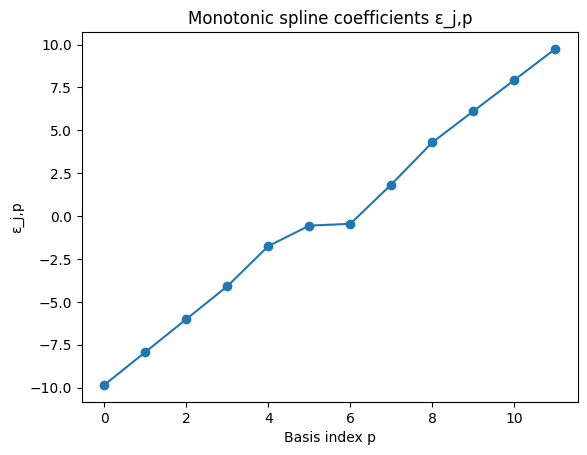

dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-9.0405, -7.8922, -5.5828, -3.8320, -2.2411, -0.9903,  0.1388,  1.3374,
         2.3239,  3.2801,  4.2360,  5.1895])


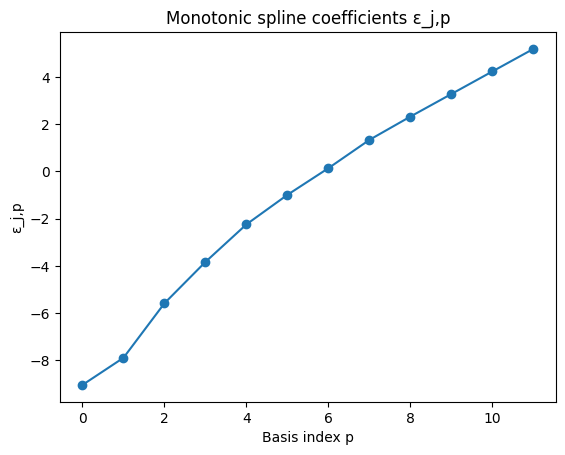

dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-9.9990, -8.1822, -6.3653, -4.5482, -2.6149, -0.5543,  0.7466,  3.4311,
         5.2770,  7.0952,  8.9134, 10.7316])


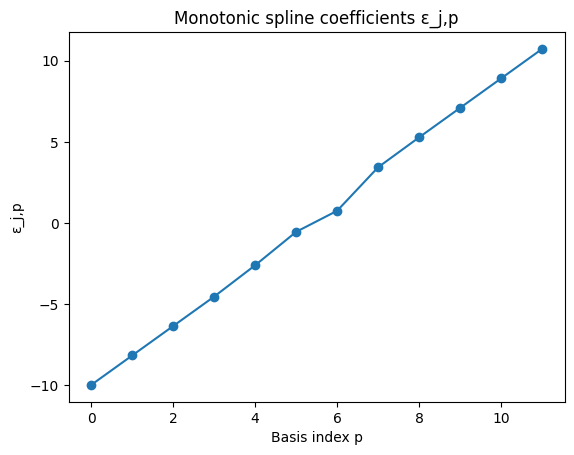

dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-9.0225, -7.9431, -5.4376, -3.6293, -2.1410, -0.5532,  0.7485,  1.7872,
         2.7595,  3.7240,  4.6806,  5.6345])


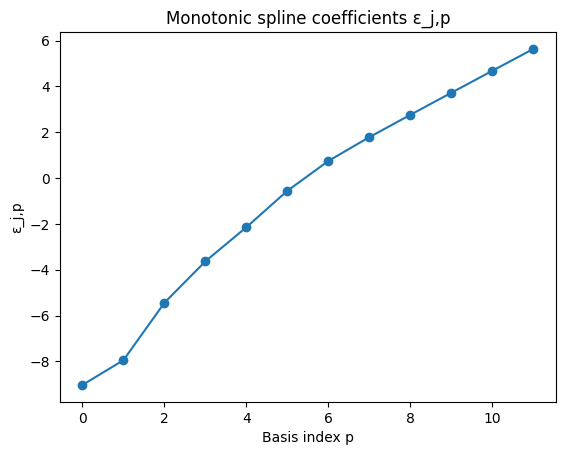

In [35]:
sanity_check(model_freq, transformation_grad=0)
sanity_check(model, transformation_grad=0)
sanity_check(model_freq, transformation_grad=1)
sanity_check(model, transformation_grad=1)

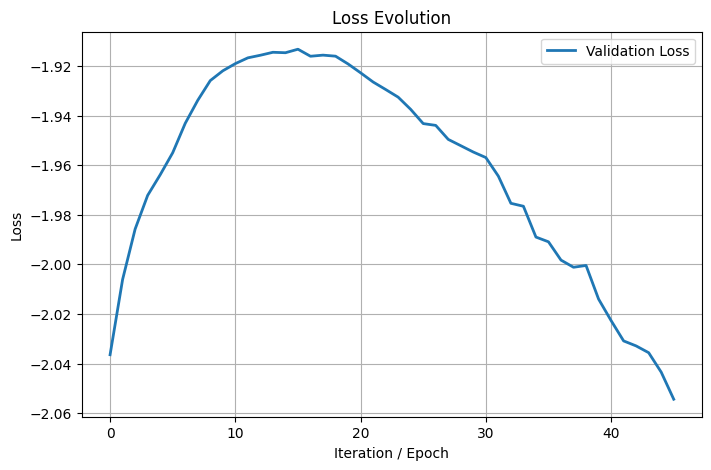

In [36]:
loss_history = output['loss_history']
val_loss = output['val_history']


# Plot            
plt.figure(figsize=(8, 5))
#plt.plot(loss_history, label="Loss", linewidth=2)
plt.plot(val_loss, label="Validation Loss", linewidth=2)
plt.xlabel("Iteration / Epoch")
plt.ylabel("Loss")
plt.title("Loss Evolution")
plt.legend()
plt.grid(True)
plt.show()

In [37]:
log_likelihood_train_bgtm = model.log_likelihood(simulated_data_train)
log_likelihood_validate_bgtm = model.log_likelihood(simulated_data_validate)
log_likelihood_test_bgtm = model.log_likelihood(simulated_data_test)


log_likelihood_train_gtm = model_freq.log_likelihood(simulated_data_train)
log_likelihood_validate_gtm = model_freq.log_likelihood(simulated_data_validate)
log_likelihood_test_gtm = model_freq.log_likelihood(simulated_data_test)

In [38]:
print("KLD BGTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_bgtm).item(),4) )
print("KLD GTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm).item(),4) )
print("KLD Gaussian Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula   Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )
print("")
print("KLD BGTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_bgtm).item(),4) )
print("KLD GTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm).item(),4) )
print("KLD Gaussian Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula   Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD BGTM      Train Data:  0.6216
KLD GTM      Train Data:  0.1552
KLD Gaussian Train Data:  -0.3396
KLD Copula   Train Data:  0.5163

KLD BGTM      Test  Data:  0.643
KLD GTM      Test  Data:  0.1745
KLD Gaussian Test  Data:  -0.2883
KLD Copula   Test  Data:  0.5431


In [39]:
model.approximate_transformation_inverse()
synthetic_samples = model.sample(10000)
model_freq.approximate_transformation_inverse()
synthetic_samples_freq = model_freq.sample(10000)

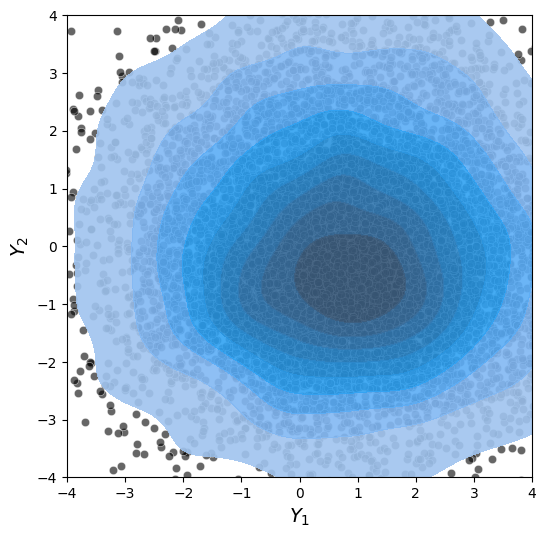

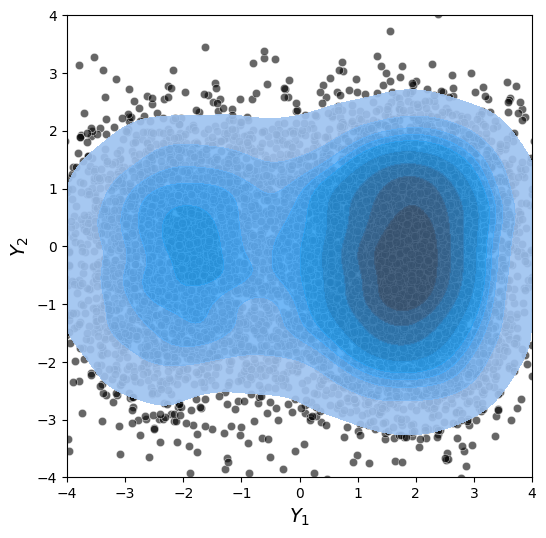

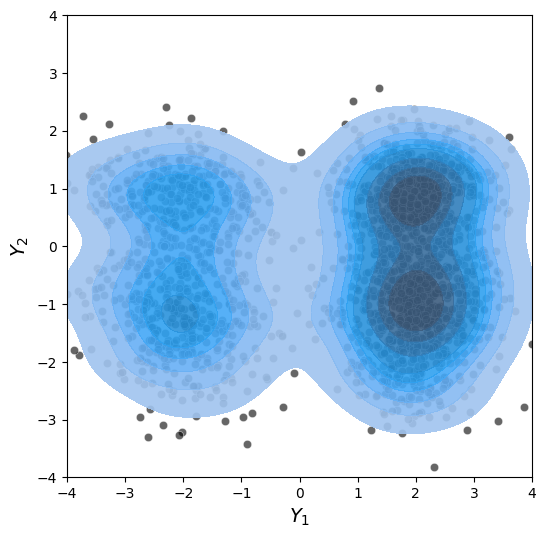

In [40]:
model.plot_densities(synthetic_samples.cpu().numpy(), x_lim=[-4,4], y_lim=[-4,4])
model_freq.plot_densities(synthetic_samples_freq, x_lim=[-4,4], y_lim=[-4,4])
model.plot_densities(simulated_data_train, x_lim=[-4,4], y_lim=[-4,4])